In [2]:
import vmo 
import vmo.analysis as van
import vmo.analysis.segmentation as vse
import csv
import numpy as np
np.set_printoptions(threshold='nan')

from collections import Counter

import math
import entropy
import matplotlib as mpl 

import matplotlib.pyplot as plt

import matplotlib.cm as cm
from matplotlib import patches
import plotly.plotly as py


import librosa

from nolds import lyap_e, lyap_r, corr_dim

import scipy as sc
import scipy.sparse as sp
from scipy.sparse import spdiags
import scipy.stats


import pylab 
import scipy.weave
import scipy.io.wavfile as wav

import operator

#from pyunicorn.timeseries import RecurrencePlot, RecurrenceNetwork

#from python_speech_features import mfcc
#from python_speech_features import logfbank

from pylab import * # show, scatter, xlim, ylim
from random import randint
from random import randrange

from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.catch_warnings()

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# time series standard embedding 
def timeseries_embedding(series=[], m=3, time_delay=1):    
    m = int(m) # m = embedding dimension = nb of columns in the embedded time series matrix
    time_delay = int(time_delay)
    
    n = len(series) 
    
    nb_vectors = n - (m-1) * time_delay # nb of vectors in the embedded time series matrix
    embedded = np.empty((nb_vectors, m), dtype="float32") # embedded series has nb_vectors rows and m columns

    #print embedded.shape
    for j in range(0, m):
        idx = j * time_delay
        
        for k in range(0,nb_vectors):
            embedded[k,j] = series[idx]
            idx += 1
    return embedded

In [4]:
# time series of logistic map with transients discarded
n = 1000 # nb of iterations, length of time series

#x0 = 0.00079
#r=3.82842712 

def logisticmap(x0, r, T):  
    r = float(r)
   
    ts = np.empty(T)
    ts[0] = x0 

    for i in range (1,T):
        x = ts[i-1]
        ts[i] = r * x * (1-x)        
    return ts

(100,)


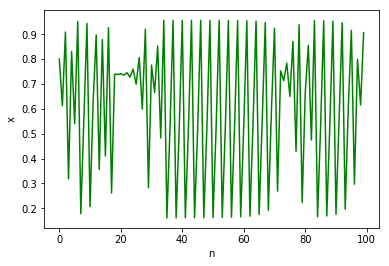

In [5]:
r = 3.8284
x0 = 0.8
T = 100
time_series = logisticmap(x0,r, T)
print time_series.shape

pylab.plot(time_series, 'g')
plt.xlabel('n')
plt.ylabel('x')

In [6]:
# embedding of time series for the following parameters:
#r = 3.8284
#x0 = 0.8
#T = 100

dim = 3
tau = 3

embedded_timeseries =  timeseries_embedding(time_series, dim, tau)

In [7]:
def VMO_GEN(embedded_timeseries, r_threshold, dim = 3):
    threshold = vmo.find_threshold(embedded_timeseries, r = r_threshold, dim = dim)
    
    #print threshold[0][1]
    
    ideal_t = threshold[0][1]
    x_t = [i[1] for i in threshold[1]]
    y_t = [i[0] for i in threshold[1]]
    
    ir = threshold[0][0]

    plt.figure(figsize=(12,2))
    plt.plot(x_t, y_t, linewidth = 2)
    plt.hold('on')
    plt.vlines(ideal_t, 0.0, max(y_t), colors = 'k',linestyle = 'dashed',linewidth = 2)
    plt.grid('on')
    plt.legend(['IR values', 'Selected threshold'], loc=1)
    plt.title('Threshold value versus Information Rate', fontsize = 18)
    plt.xlabel('Threshold Value',fontsize = 14)
    plt.ylabel('Summed IR', fontsize = 14)
    plt.tight_layout()
    
    
    ts_vmo = vmo.build_oracle(embedded_timeseries, flag='a', threshold=ideal_t, dim=dim)

    methods = ['sfx', 'lrs', 'rsfx']

    plt.figure(figsize = (12,4))
    for i,m in enumerate(methods):
        recurrence_vmo = van.create_selfsim(ts_vmo, method=m)
        
        plt.subplot(1,3,i+1)
        plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Greys')
    
        plt.title(m, fontsize=14)
        plt.tight_layout()
    
    
    return [ts_vmo, threshold[0][1], ir]
    

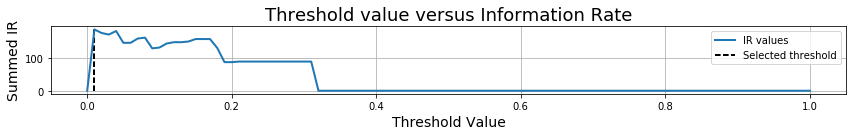

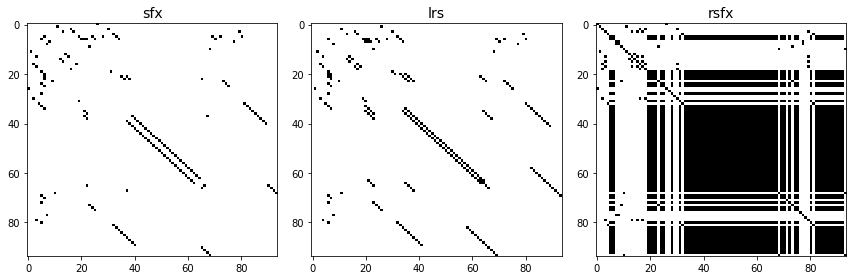

In [8]:
r_threshold = (0, 1.01, 0.01)

TS_VMO = VMO_GEN(embedded_timeseries, r_threshold, dim=3)

In [9]:
def Recurrence_VMO(TS_VMO):
    recurrence_vmo = van.create_selfsim(TS_VMO, method='lrs')
    
    return recurrence_vmo

    #plt.figure(figsize = (6,4))
    #plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Blues')
    #plt.title('lrs', fontsize=14)

In [10]:
def Recurrence_Rate(recurrence_vmo):
    ln= len(recurrence_vmo)
    RR = (np.sum(recurrence_vmo))/float(ln*ln)    
    return RR

In [11]:
# CORRELATION SUM i.e. estimates the CORRELATION DIMENSION D2
def Correlation_Sum(recurrence_vmo):
    ln = len(recurrence_vmo)
    C = (np.sum(recurrence_vmo) - np.sum(recurrence_vmo.diagonal()))/float(ln*ln)
    return C
 

In [12]:
# CORRELATION ENTROPY (2nd order Rényi entropy)
def Correlation_Entropy(recurrence_vmo):
    C = Correlation_Sum(recurrence_vmo)
    K2 = -log(C)
    return K2

In [13]:
def Determinism(recurrence_vmo, diagonal_sum):    
    nume = diagonal_sum #np.sum(L)
    denom = np.sum(recurrence_vmo)
    if (denom > 0):
        DET =  nume / denom        
    else: 
        DET = -1#'NA'
        
    return DET

In [14]:
def Laminarity(recurrence_vmo, vsum):
    if (np.sum(recurrence_vmo) != 0):
        LAM = vsum / np.sum(recurrence_vmo)        
    else:
        LAM = -1#'NA'
        
    return LAM


In [15]:
def Divergence(lmax):
    if (lmax > 0):
        DIV = np.divide(1,lmax) 
    else:
        DIV = -1#'NA'
        
    return DIV
    

In [16]:
def Diagonals(recurrence_vmo):
    # DIAGONALS
    LOI = 0
    newd = {}
    mat = np.zeros((recurrence_vmo.shape[0]*2+1,recurrence_vmo.shape[1]))

    for ii in range(-len(recurrence_vmo), len(recurrence_vmo)):    
        newd[ii]= np.diagonal(recurrence_vmo, offset = ii) 


    for rw in range (0, len(recurrence_vmo)): 
        for cl in range (0, len(recurrence_vmo)):
            if(rw == cl):
                if (recurrence_vmo[rw][cl] == 1):
                    LOI += 1
        
    for i in range (-len(recurrence_vmo), len(recurrence_vmo)):   
        for j in range(len(newd[i])):
            mat[i+len(recurrence_vmo),j] = newd[i][j] 

    diag_idx = 0

    diagonals = np.zeros(recurrence_vmo.size)
    for drow in range(0, len(mat)):    
        diag_sum = 0
        for dcol in range(0, mat.shape[1]):       
            if (mat[drow,dcol] == 1):
                diag_sum += 1           
            if (mat[drow,dcol] == 0):
                if (diag_sum > 0):
                    diagonals[diag_idx] = diag_sum
                    diag_idx += 1
                    diag_sum = 0
        if (diag_sum > 0):
            diagonals[diag_idx] = diag_sum;
            diag_idx += 1
        
        
    dia_cnt = 0
    dia_sum = 0
    for indx in range(0, len(diagonals)):
        if (diagonals[indx] >= 2):
            dia_sum += diagonals[indx]
            dia_cnt += 1

    if (dia_cnt > 0):
        av_diag = dia_sum / dia_cnt        
    else: 
        av_diag = -1#'NA'    

        
        
    # Longest Diagonal Length without the Line of Identity (LOI):
    newdiag = np.copy(diagonals) # copy array into array newdiag

    max_idx= np.argmax(newdiag)  # get the index of the longest diagonal (could be LOI)

    newdiag[max_idx] = -1 # remove the index of LOI
    L_max = newdiag.max()  # get the second longest diagonal
    
    return [dia_sum, L_max, diagonals, av_diag]

In [17]:
def Verticals(recurrence_vmo):
    
    #find vertical lines
    idx = 0
    vertical = np.zeros(recurrence_vmo.size)
    for c in range(0, recurrence_vmo.shape[1]):       
        s = 0
        for r in range(0, len(recurrence_vmo)):
            if (recurrence_vmo[r,c] == 1):
                s += 1           

            if (recurrence_vmo[r,c] == 0):
                if (s > 0):
                    vertical[idx] = s
                    idx += 1
                    s = 0
        if (s > 0):
            vertical[idx] = s;
            idx += 1


    vcnt = 0
    vsum = 0
    for V in range(0, len(vertical)):
        if (vertical[V] >= 2):
            vsum += vertical[V]
            vcnt += 1

    #----------------------------------------------------------------------------------------------------------   
    # Longest Vertical Line
    V_max = vertical.max()
    
    #----------------------------------------------------------------------------------------------------------   
    # TRAPPING TIME
    if (vcnt > 0):
        TT = vsum /vcnt        
    else: 
        TT = -1#'NA'   
    
    return [vsum, V_max, vertical, TT]
    


In [18]:
def RQA(TS_VMO):
    
    rqa = np.empty(19)
    nld = 0
    
    
    recurrence_vmo = Recurrence_VMO(TS_VMO)
    
    #----------------------------------------------------------------------------------------------------------    
    # RECURRENCE RATE    
    RR = Recurrence_Rate(recurrence_vmo)    
    rqa[nld] = RR
    nld+=1
    #----------------------------------------------------------------------------------------------------------    
    # DIAGONALS
    #dia_sum, L_max, av_diag 
    
    diag_stats = Diagonals(recurrence_vmo) # diag_stats: [dia_sum, L_max, diagonals, av_diag]
    
    dia_sum = diag_stats[0]
    L_max = diag_stats[1]
    diagonals = diag_stats[2]
    av_diag = diag_stats[3]
    
    rqa[nld] = dia_sum
    nld+=1
    rqa[nld] = L_max
    nld+=1
    
    #----------------------------------------------------------------------------------------------------------
    # DETERMINISM  
    
    DET = Determinism(recurrence_vmo, dia_sum)
    rqa[nld] = DET
    nld+=1
    
    #----------------------------------------------------------------------------------------------------------    
      
    # Divergence        
    DIV = Divergence(L_max)
    rqa[nld] = DIV
    nld+=1
   
    #----------------------------------------------------------------------------------------------------------
     # Entropy of diagonal line lengths
    u, inv = np.unique(diagonals, return_inverse=True)
    n = np.bincount(inv)

    L_entr = 0

    for i in range(0, len(n)):
        L_entr += - (float(n[i])/float(len(diagonals))) * math.log(float(n[i])/float(len(diagonals)),2)
        
    rqa[nld] = L_entr
    nld+=1

    #print entropy.shannon_entropy('diagonals')
    #----------------------------------------------------------------------------------------------------------
    
    #find Vertical lines
    
    vert_stats = Verticals(recurrence_vmo)
    
    vsum = vert_stats[0]
    V_max = vert_stats[1]
    vertical = vert_stats[2]
    TT = vert_stats[3] # Trapping Time
                     
    rqa[nld] = V_max
    nld+=1
    
        
    #----------------------------------------------------------------------------------------------------------
    # Trapping Time
    rqa[nld] = TT
    nld+=1
    
    #---------------------------------------------------------------------------------------------------------- 
    # LAMINARITY    
    LAM = Laminarity(recurrence_vmo, vsum)
    rqa[nld] = LAM
    nld+=1
    #----------------------------------------------------------------------------------------------------------

    # Entropy of verticals
    uv, vinv = np.unique(vertical, return_inverse=True)
    nv = np.bincount(vinv)

    V_entr = 0

    for iv in range(0, len(nv)):
        V_entr += - (float(nv[iv])/float(len(vertical))) * math.log(float(nv[iv])/float(len(vertical)),2)
        
    rqa[nld] = V_entr
    nld+=1

    #shan = entropy.shannon_entropy('vertical')
    #----------------------------------------------------------------------------------------------------------
  
    # find white vertical lines
    indx = 0
    white = np.zeros(recurrence_vmo.size)
    for col in range(0, recurrence_vmo.shape[1]):    
        sm = 0
        for row in range(0, len(recurrence_vmo)):
            if (recurrence_vmo[row,col] == 0):
                sm += 1     
            if (recurrence_vmo[row,col] == 1):
                if (sm > 0):
                    white[indx] = sm
                    indx += 1
                    sm = 0
        if (sm > 0):
            white[indx] = sm;
            indx += 1

    wcnt = 0
    wsum = 0
    for w in range(0, len(white)):
        if (white[w] >= 2):
            wsum += white[w]
            wcnt += 1

    if (wcnt > 0):
        W = wsum /wcnt
        rqa[nld] = W
        nld+=1
    else: 
        W = 'NA'

    #----------------------------------------------------------------------------------------------------------

    W_max = white.max()  # longest white vertical line
    rqa[nld] = W_max
    nld+=1

    #----------------------------------------------------------------------------------------------------------

    # Entropy of white vertical lines
    w, winv = np.unique(white, return_inverse=True)
    wn = np.bincount(winv)

    W_entr = 0

    for w in range(0, len(wn)):
        W_entr += - (float(wn[w])/float(len(white))) * math.log(float(wn[w])/float(len(white)),2)
        
    rqa[nld] = W_entr
    nld+=1

    #white_shan = entropy.shannon_entropy('white')

    #----------------------------------------------------------------------------------------------------------

    # DET / RR

    if (RR > 0):
        DET_RR_ratio = np.divide(DET, RR)
        rqa[nld] = DET_RR_ratio
        nld+=1
    else:
        RR = 'NA'

    #----------------------------------------------------------------------------------------------------------
    # LAM / DET

    if (DET > 0): 
        LAM_DET_ratio = np.divide(LAM, DET)
        rqa[nld] = LAM_DET_ratio
        nld+=1
    else:
        LAM_DET_ratio = 'NA'

    #----------------------------------------------------------------------------------------------------------
   
    #print "Kolmogorov-Sinai Entropy lower-bound estimate with Correlation Entropy (K2):", K2
    print "RR =", RR
    print "DET=", DET
    print "Average diagonal line length=",  av_diag 
    print "Longest Diagonal Length (L_max)", L_max
    print "Divergence (DIV)=", DIV
    print "Entropy diagonal lines (L_entr):", L_entr
    print "Laminarity (LAM)=", LAM
    print "Trapping Time: Average Vertical Line Length (TT)=", TT
    print "Longest Vertical Line", V_max
    print "Entropy vertical lines (V_entr):", V_entr
    print "RATIO: (DET/RR)=", DET_RR_ratio
    print "LAM / DET=", LAM_DET_ratio
    print "Average White Vertical Line Length (W):", W
    print "Longest White Vertical Line Length (W_max):", W_max
    print "Entropy white vertical lines (W_entr):", W_entr
    
    return rqa

In [19]:
# Function: Lyapunov exponents of time series obtained for different r values of the bifurcation points
#def lyapunov_exponent(timeseries, R):
#    lyap_exp = 0    
#    lyap_exp += log(abs(R - 2 * R * timeseries)).mean()
#    return lyap_exp

In [20]:
# Function: Lyapunov exponents of recurrence_VMO SSM obtained for different r values of the bifurcation points
def lyapunov_exponent(tsvmo, R):
    lyap_exp = 0    
    lyap_exp += log(abs(R - 2 * R * np.asarray(tsvmo))).mean()
    return lyap_exp

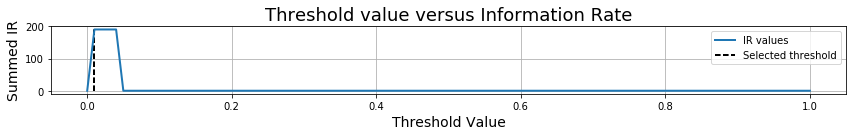

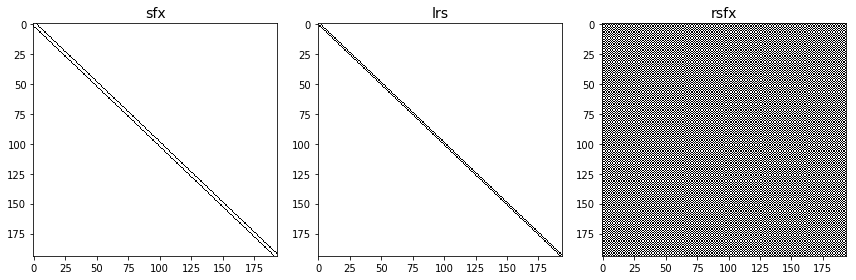

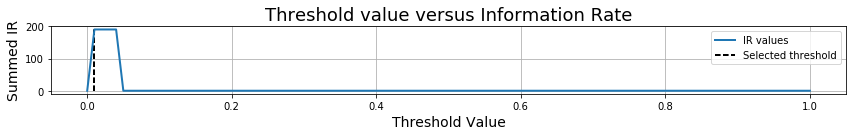

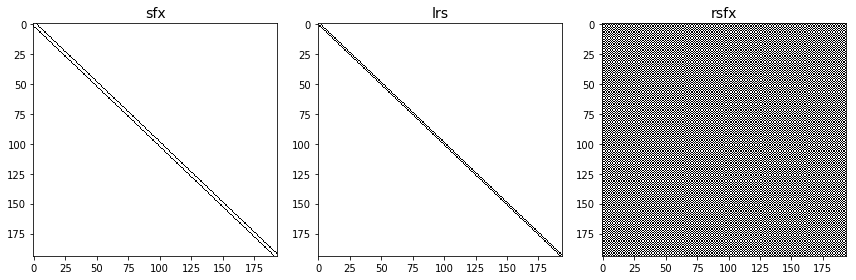

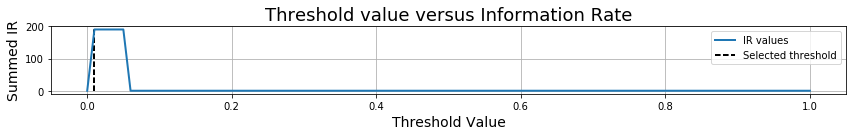

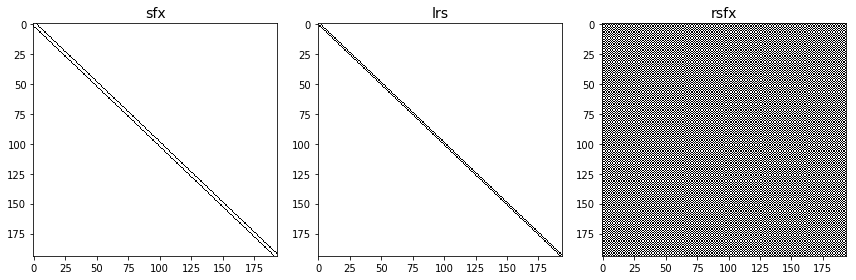

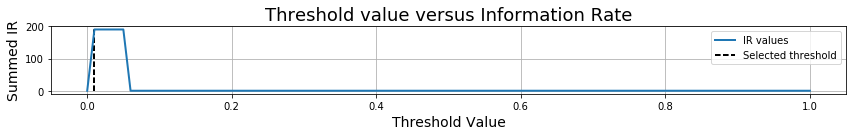

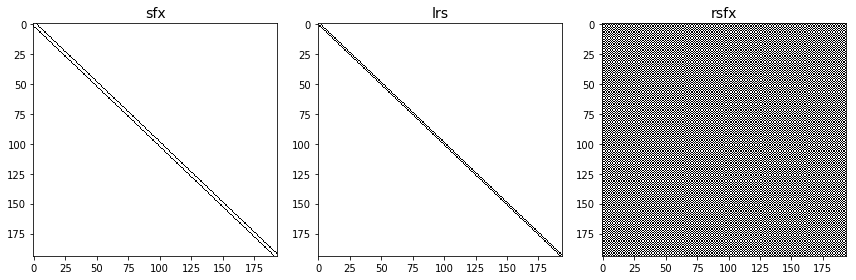

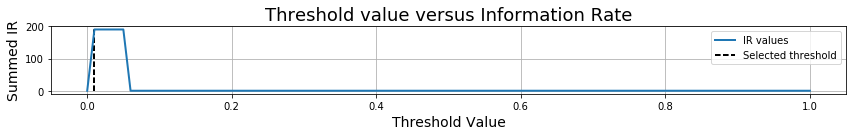

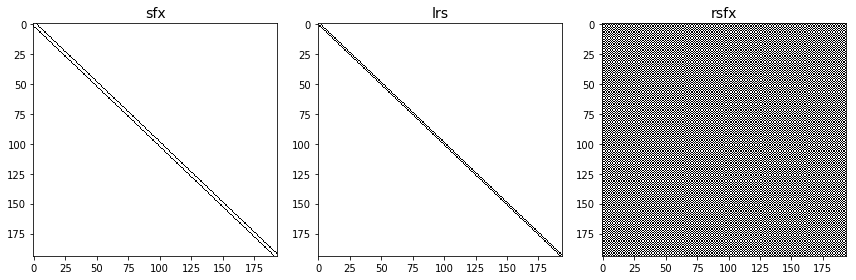

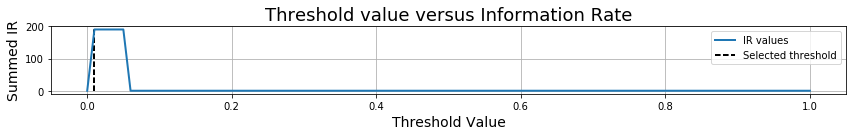

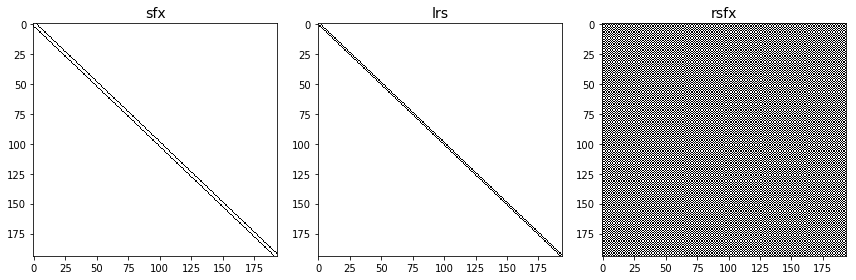

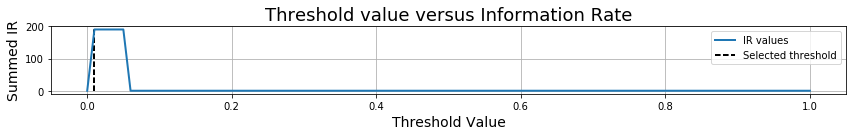

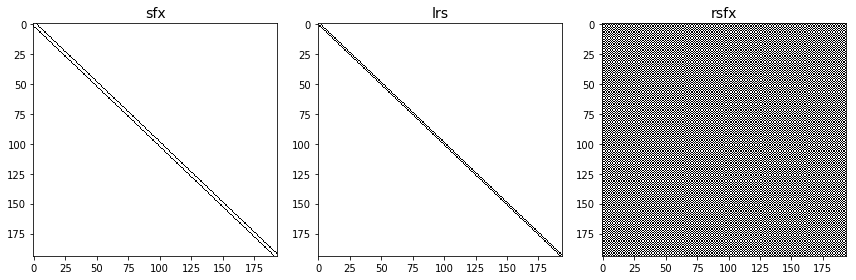

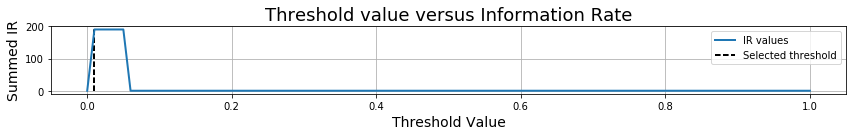

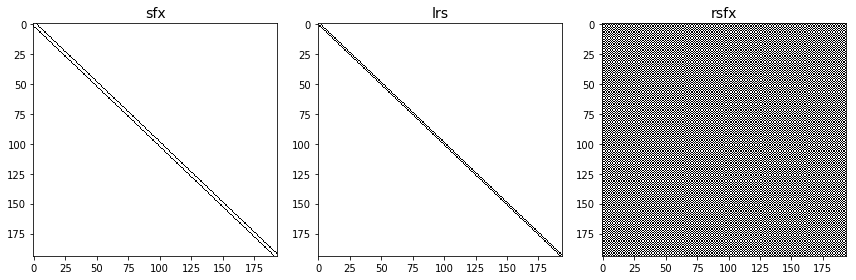

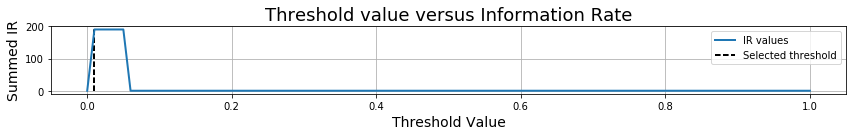

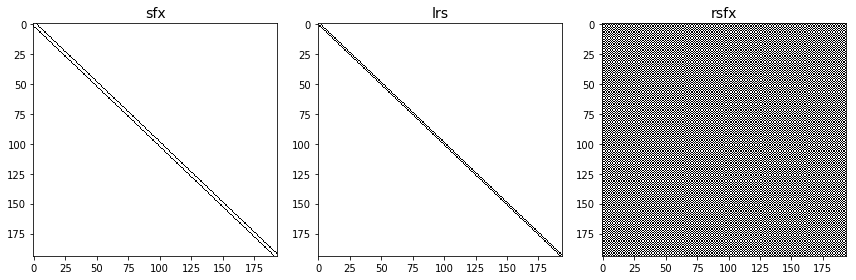

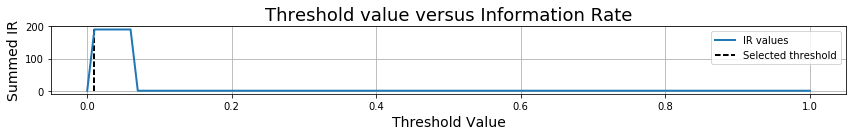

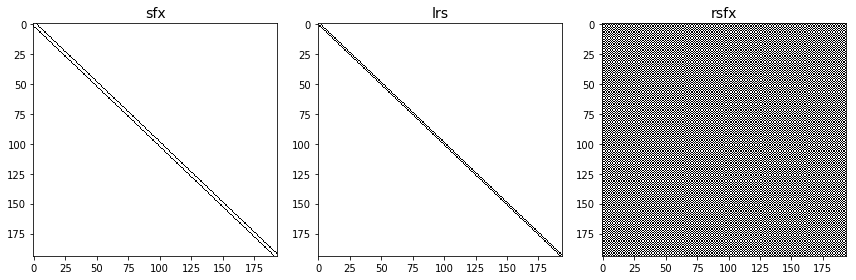

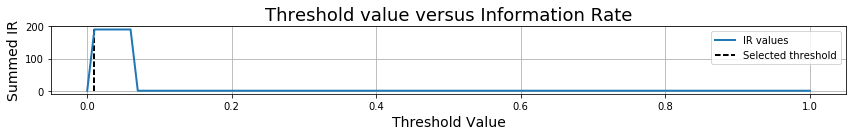

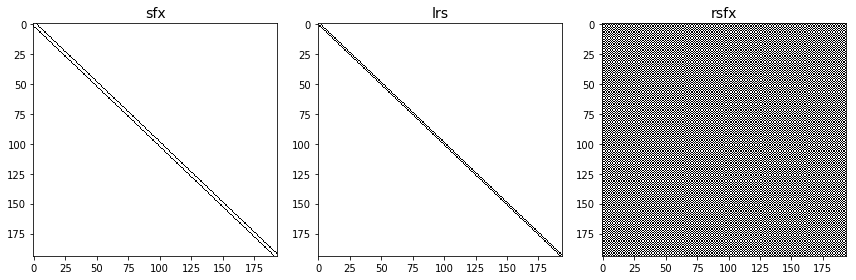

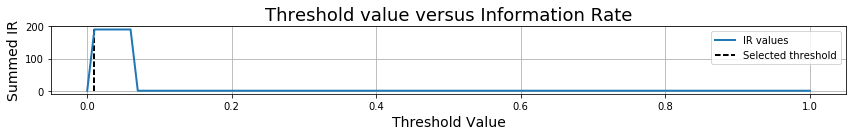

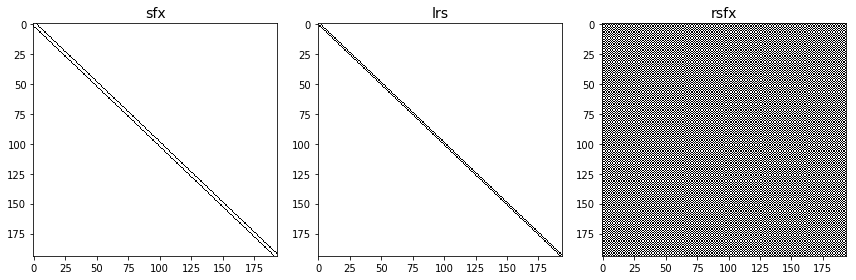

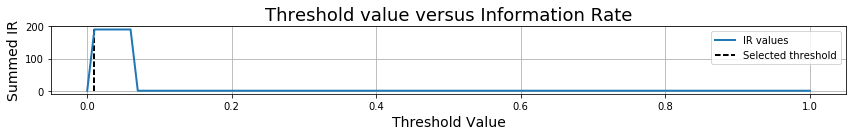

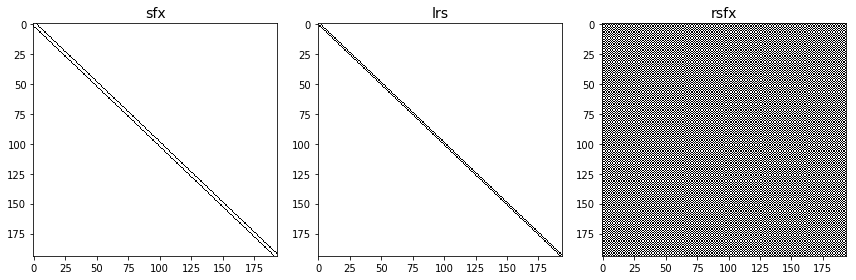

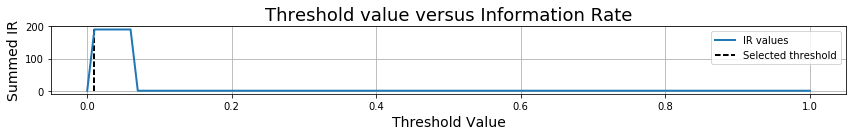

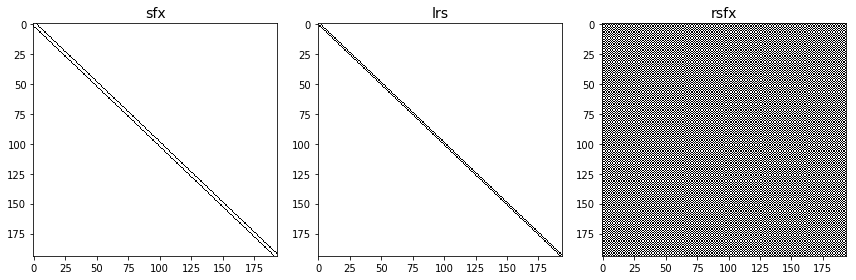

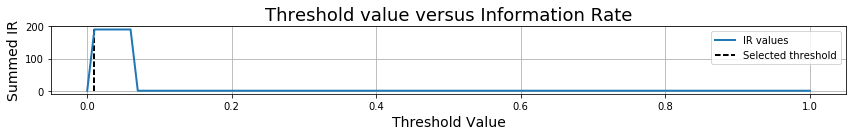

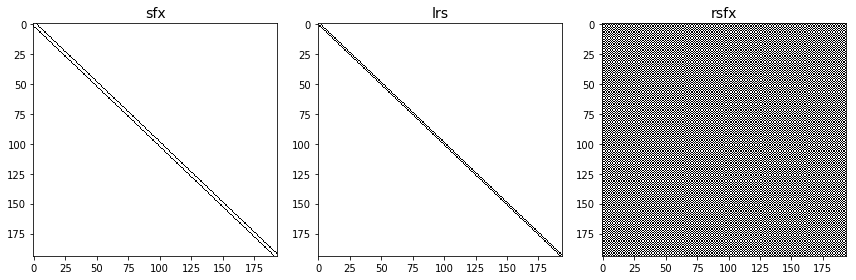

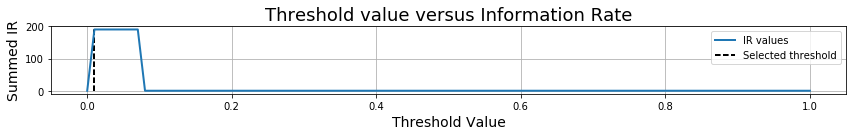

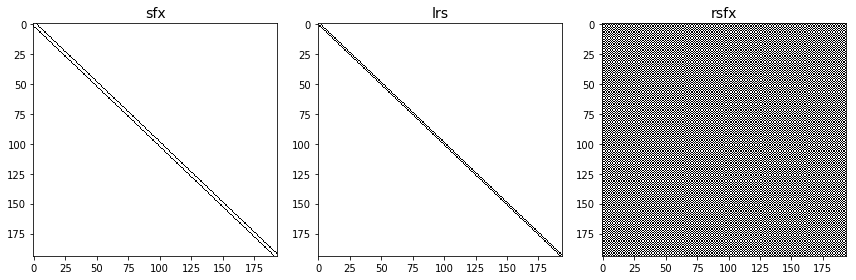

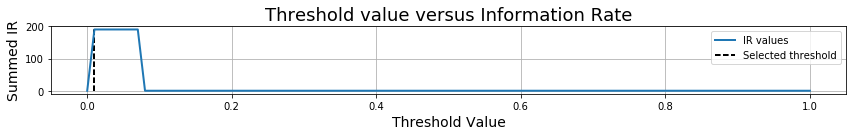

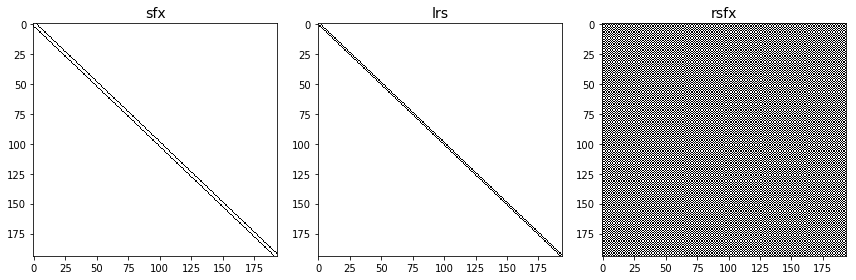

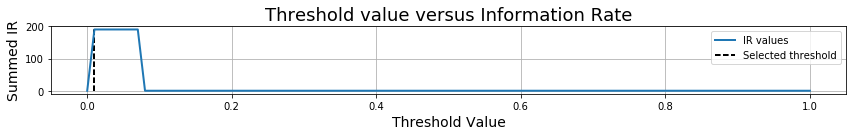

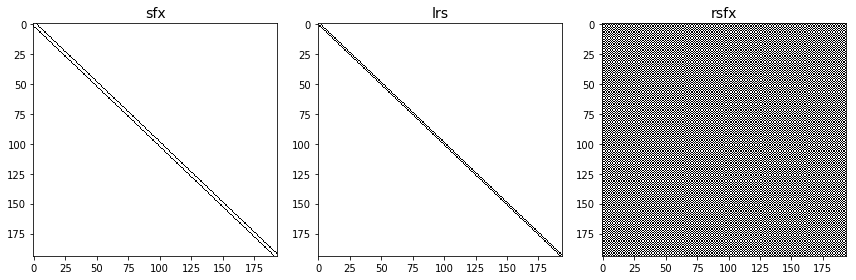

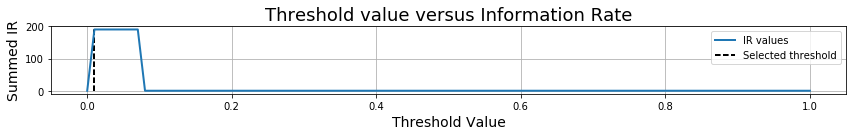

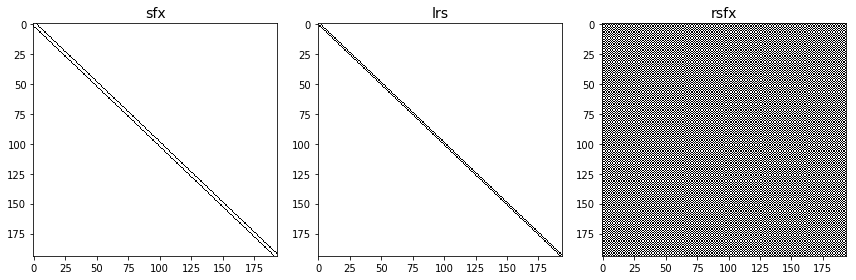

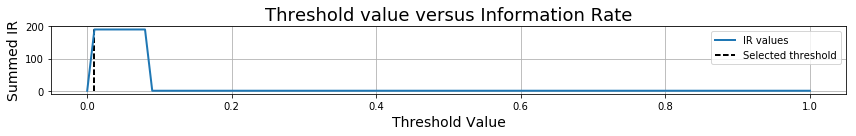

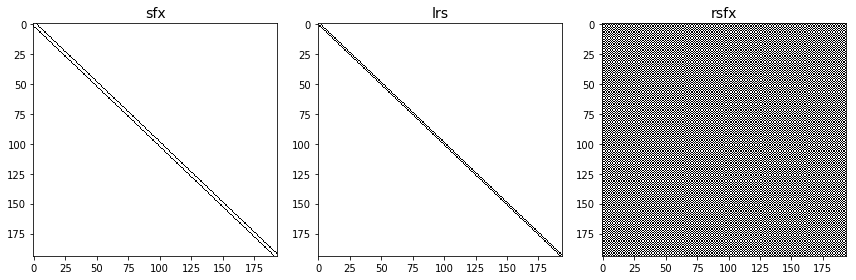

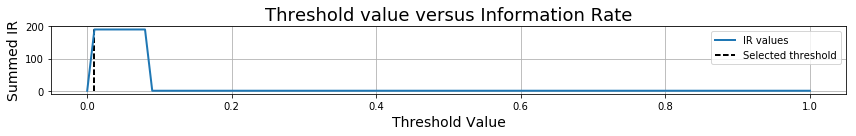

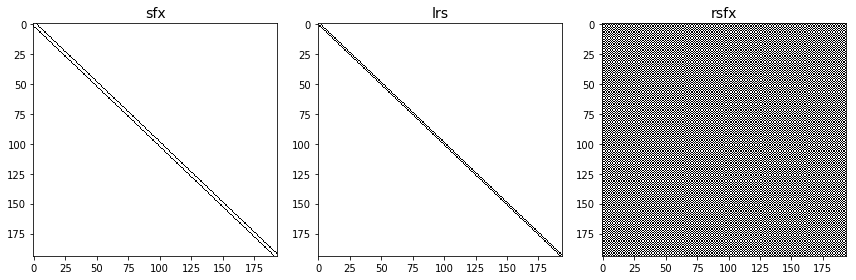

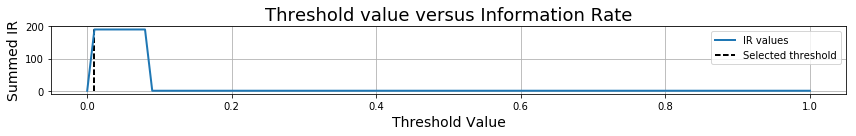

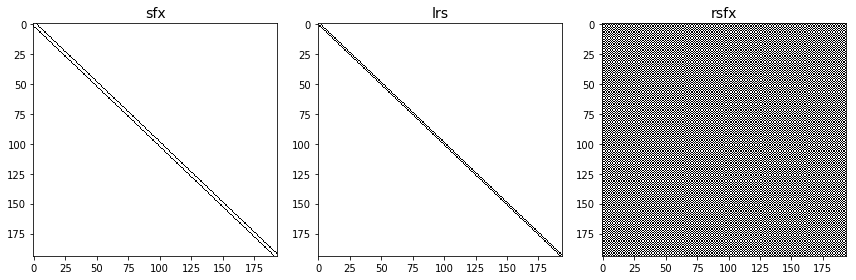

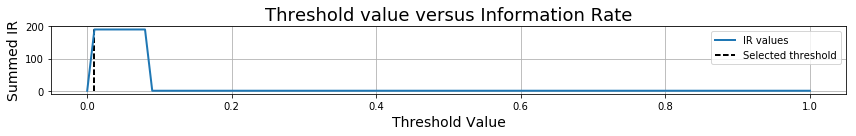

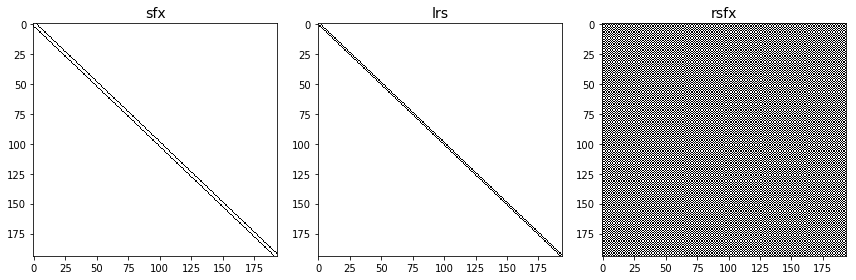

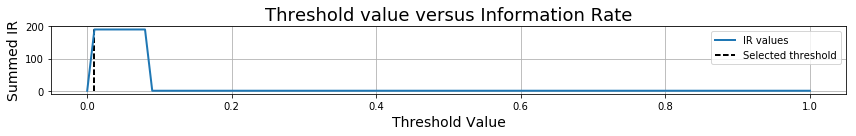

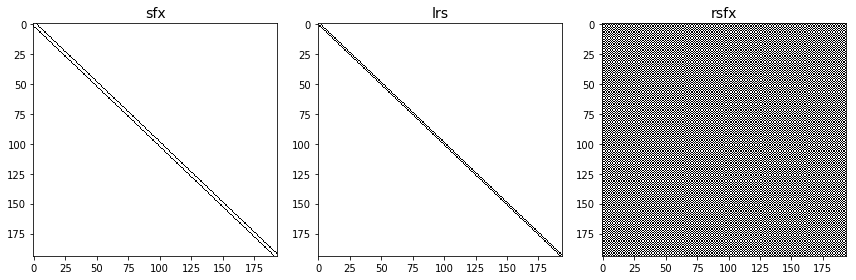

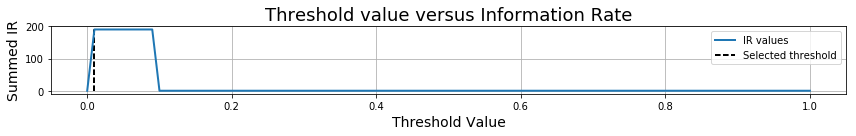

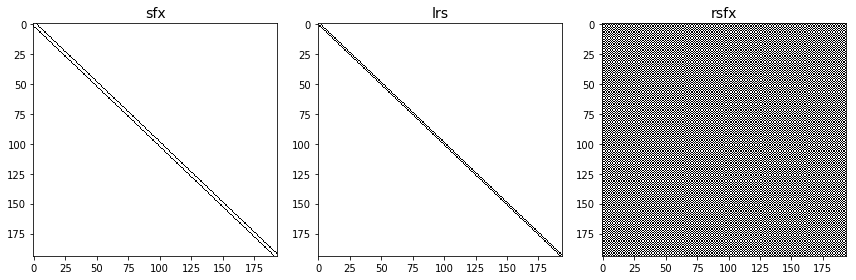

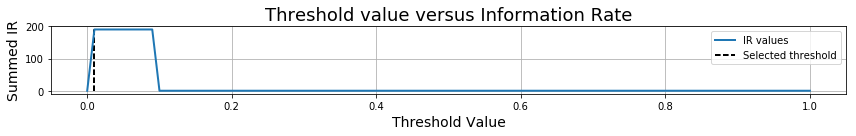

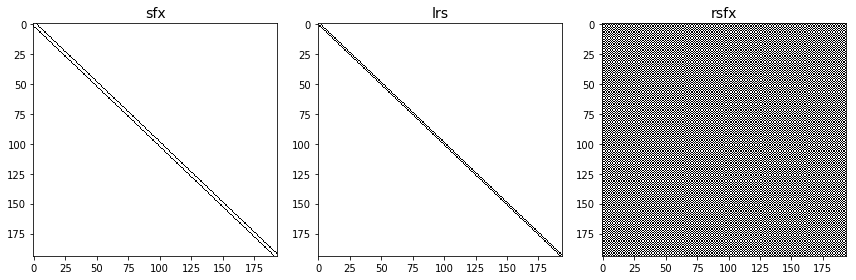

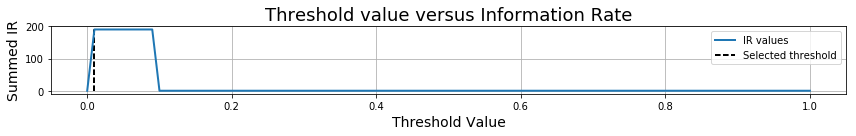

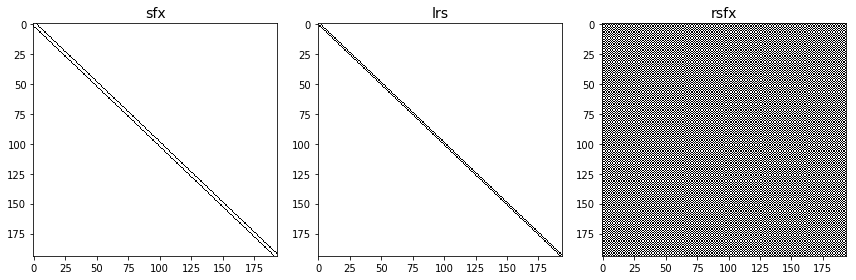

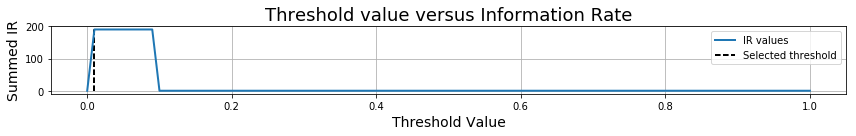

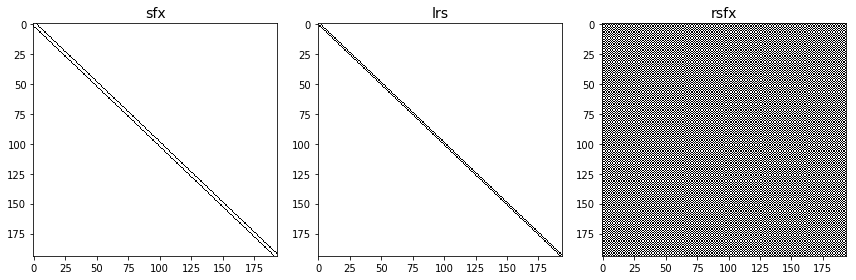

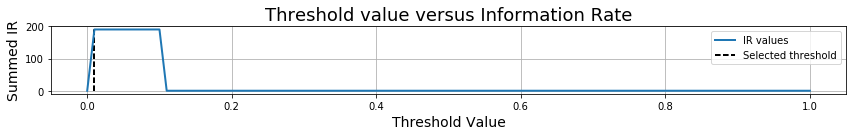

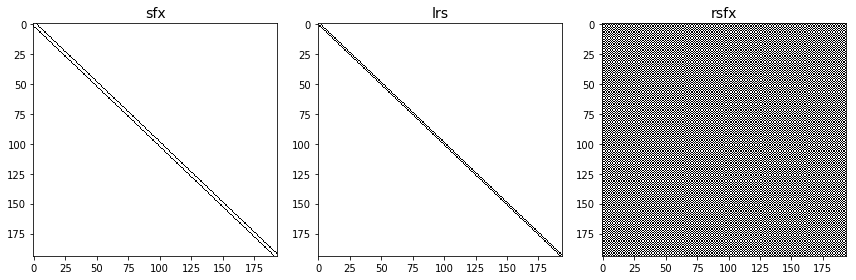

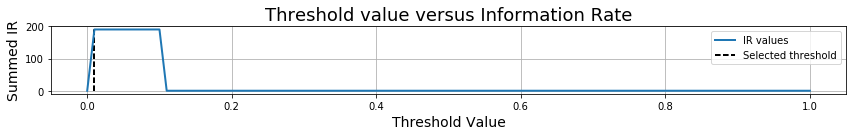

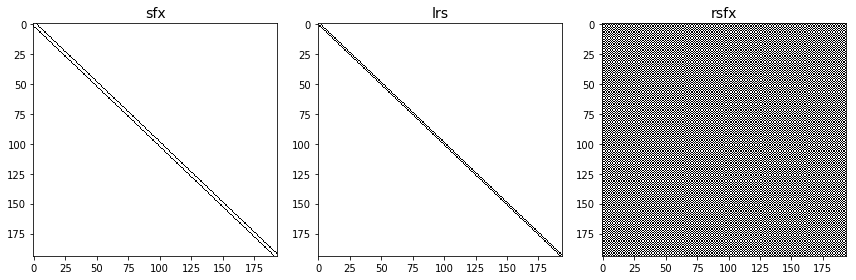

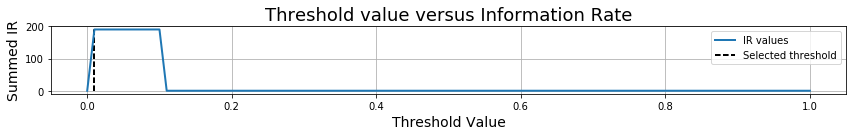

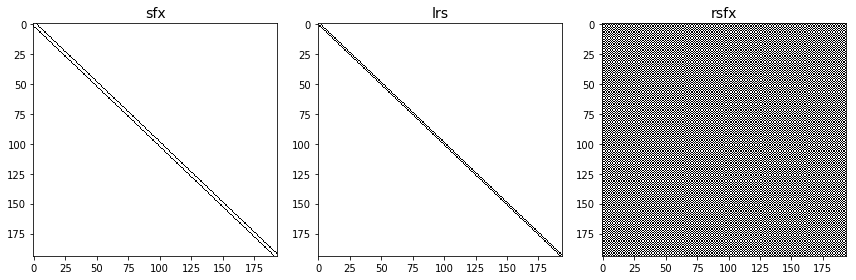

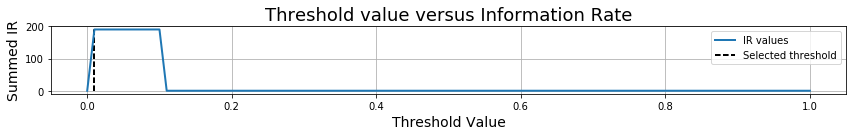

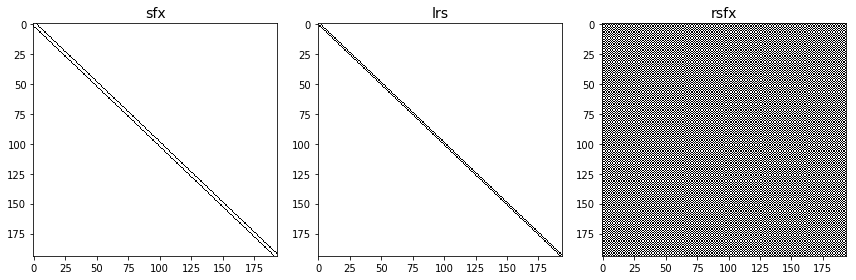

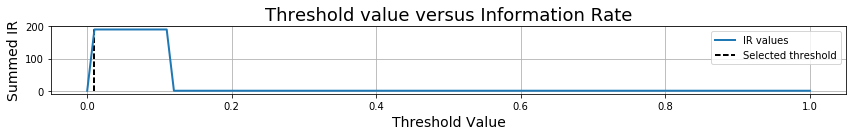

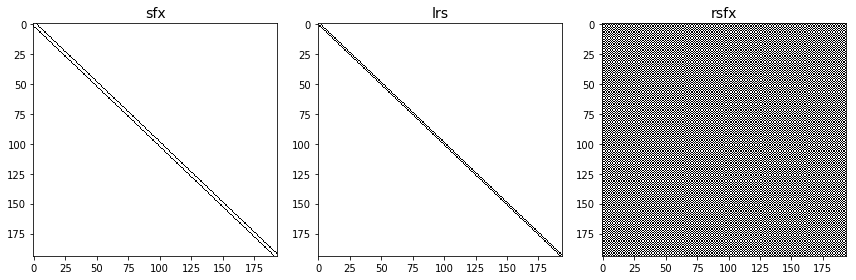

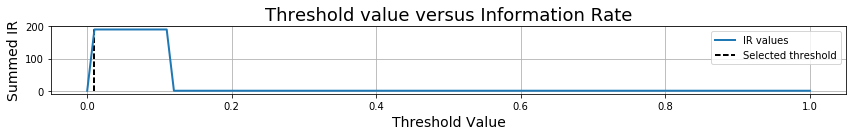

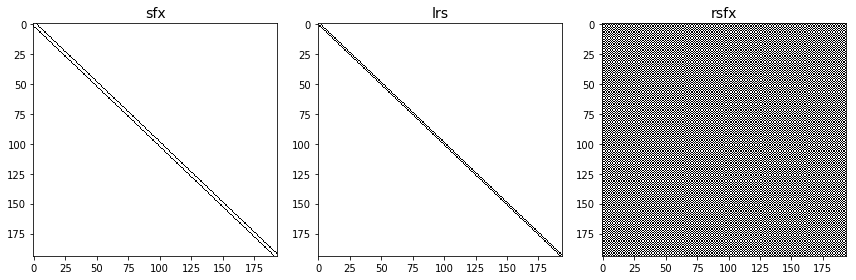

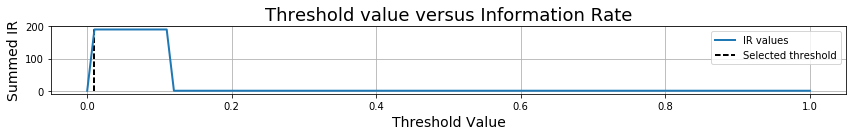

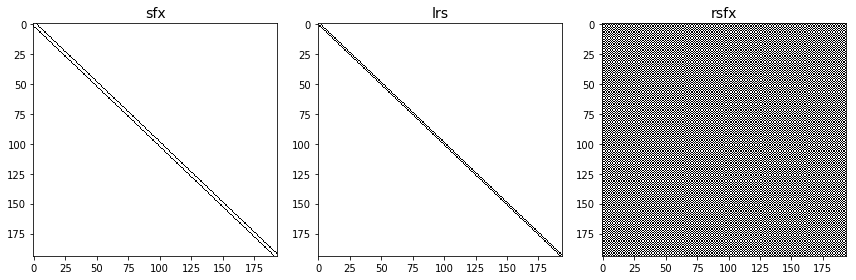

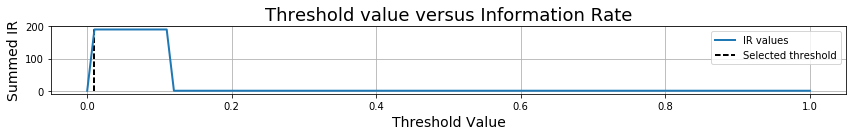

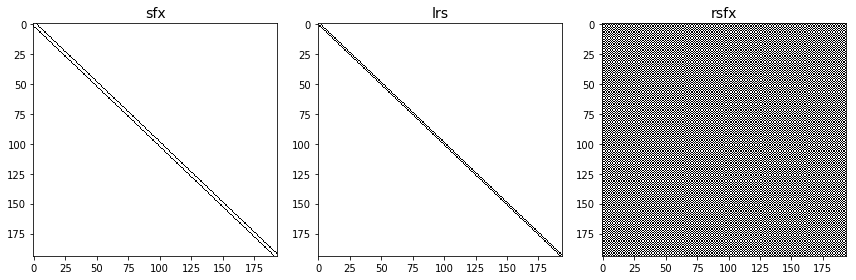

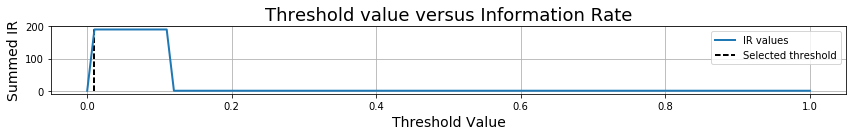

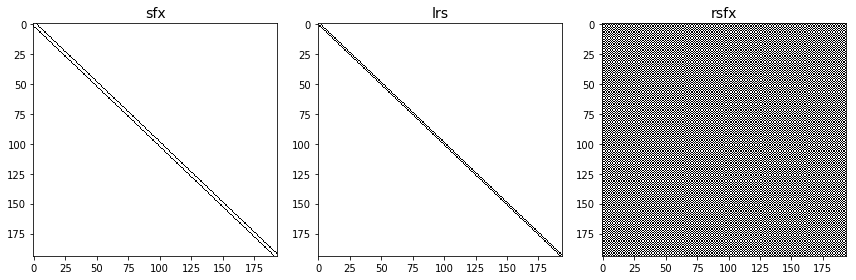

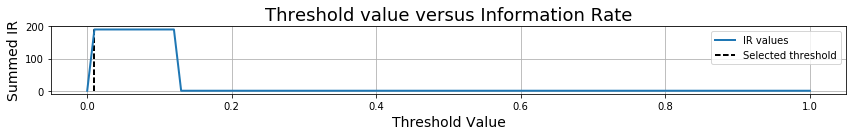

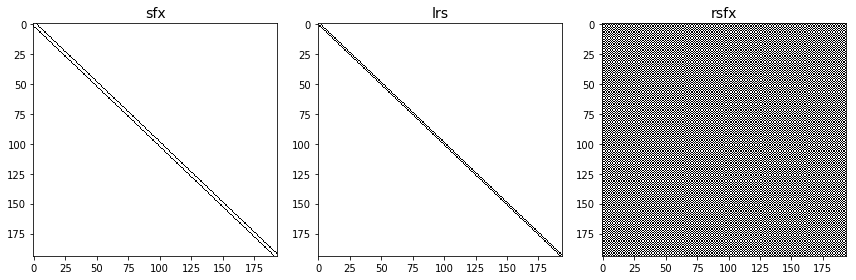

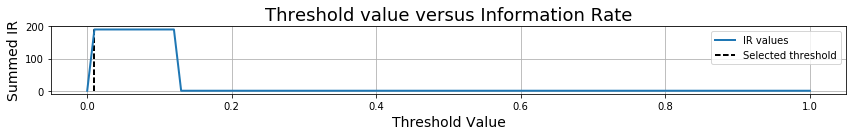

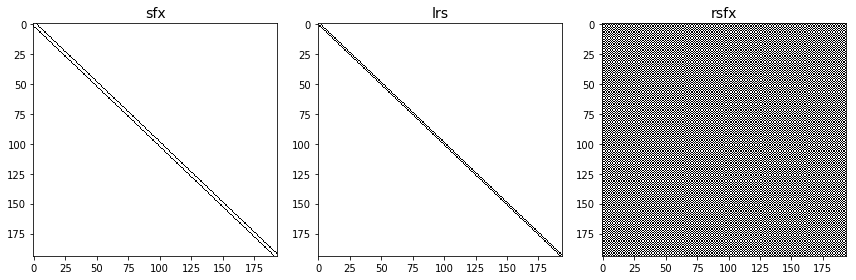

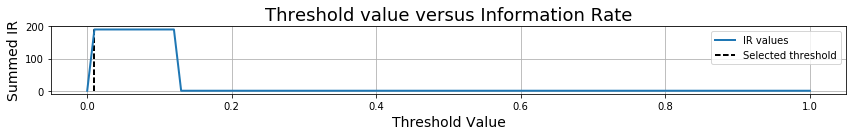

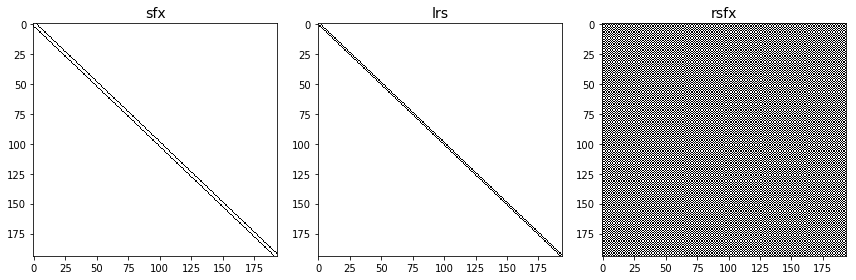

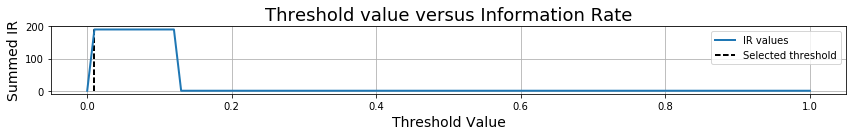

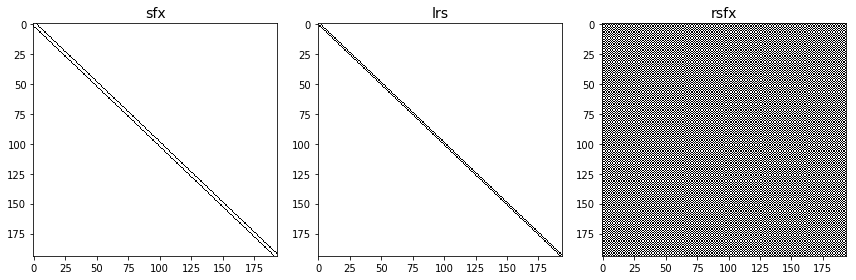

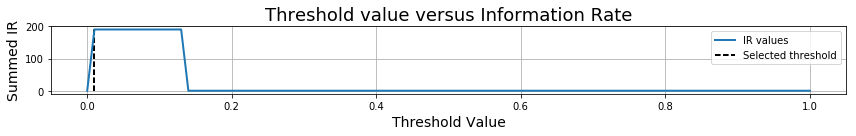

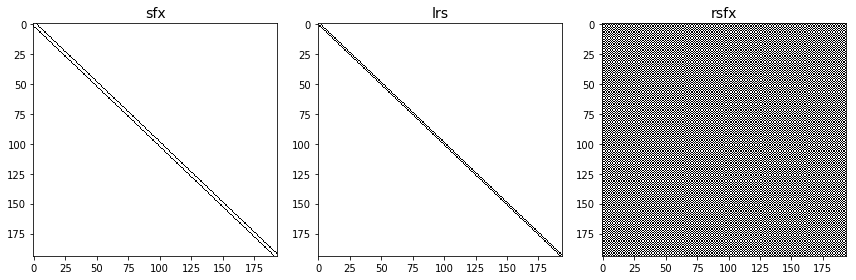

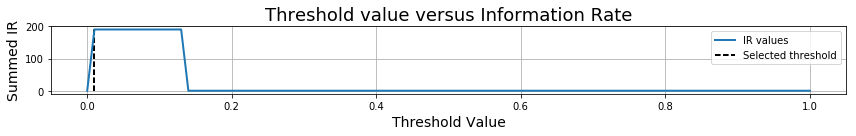

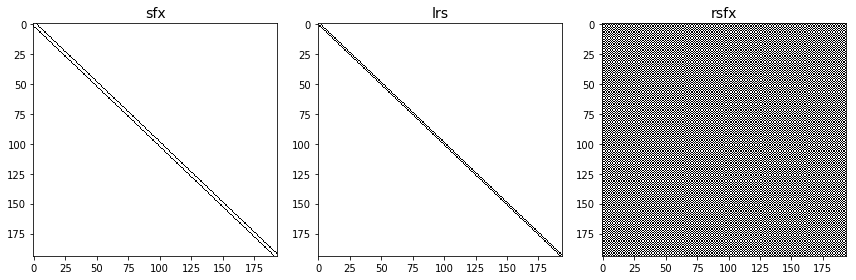

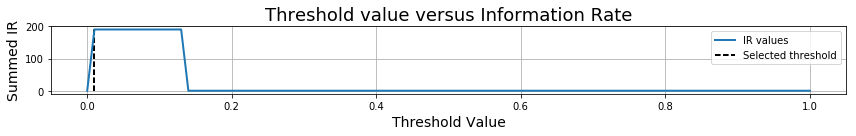

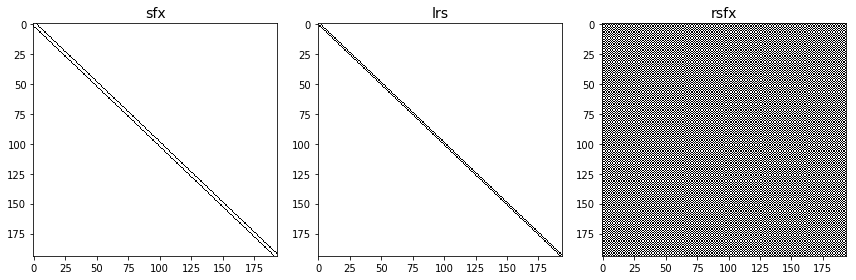

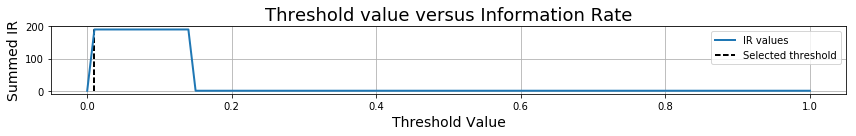

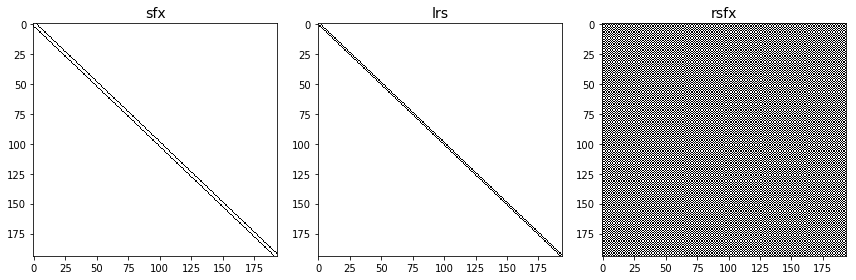

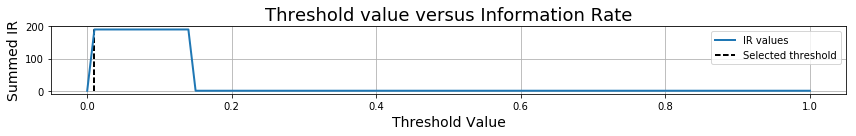

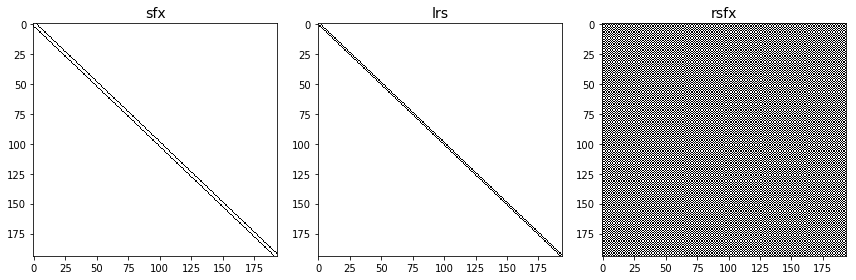

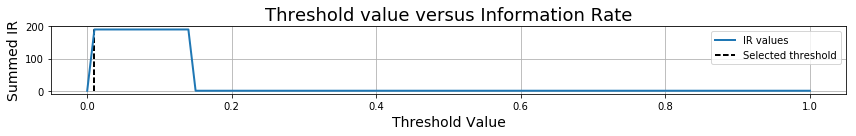

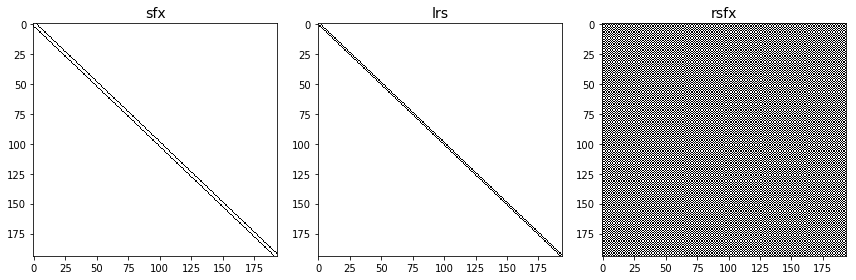

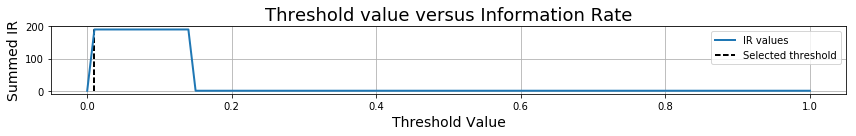

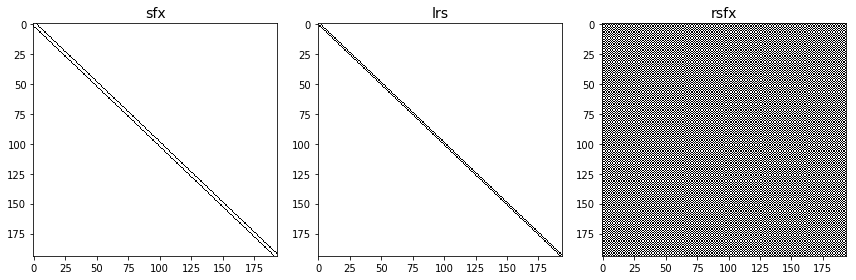

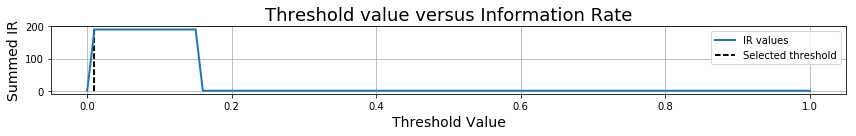

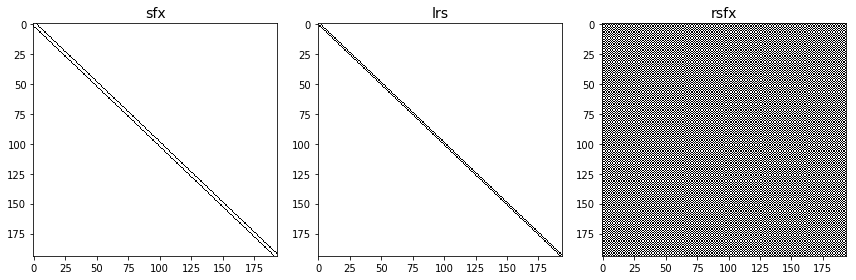

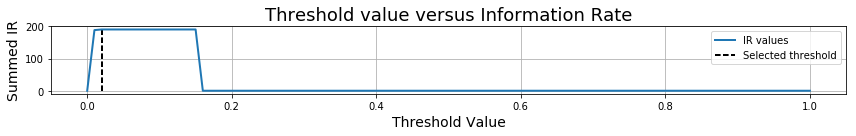

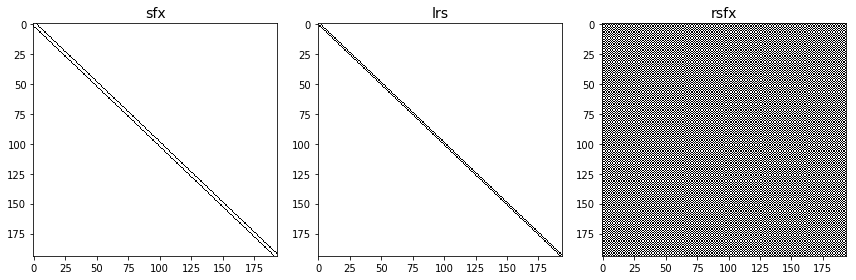

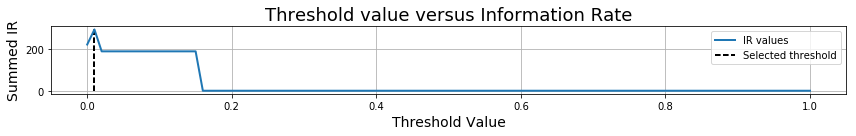

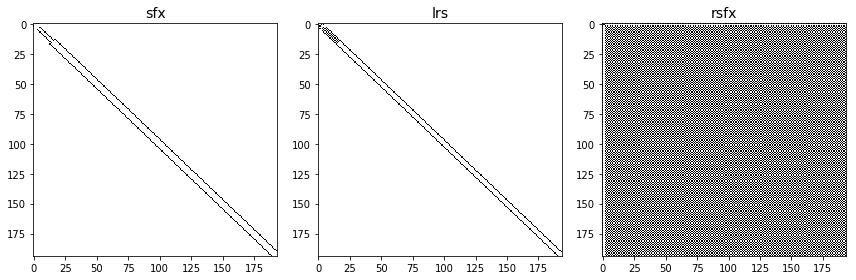

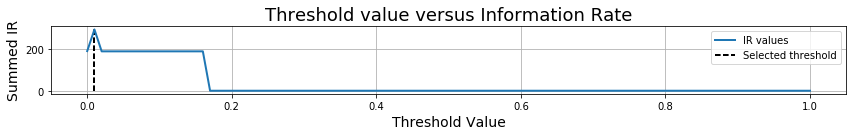

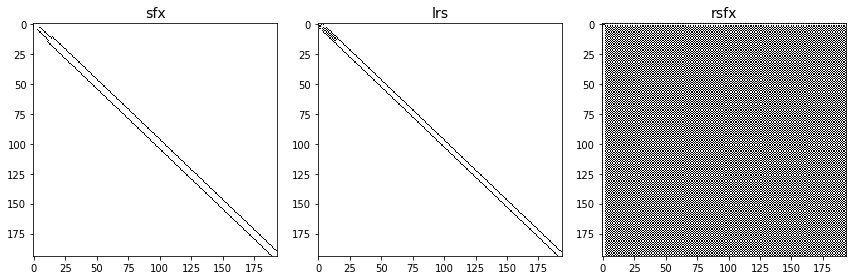

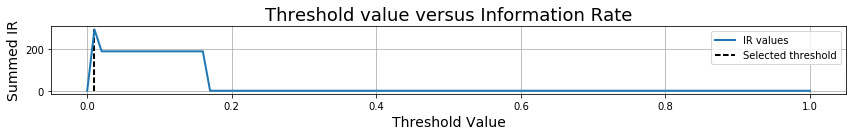

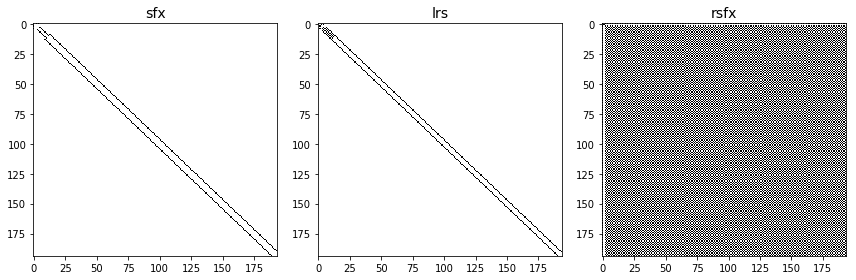

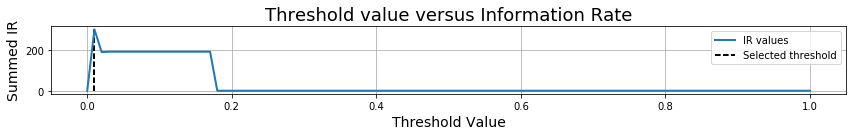

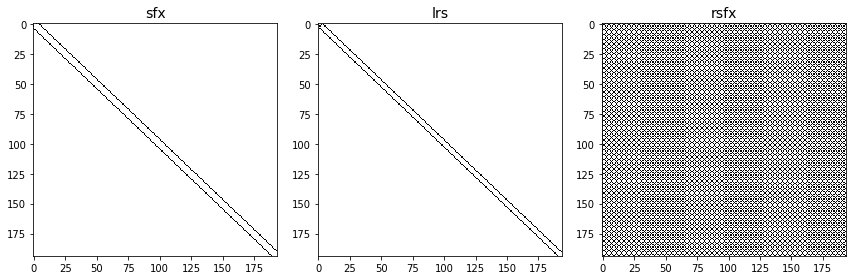

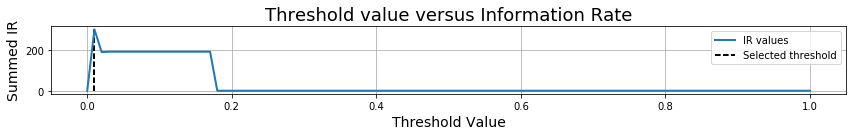

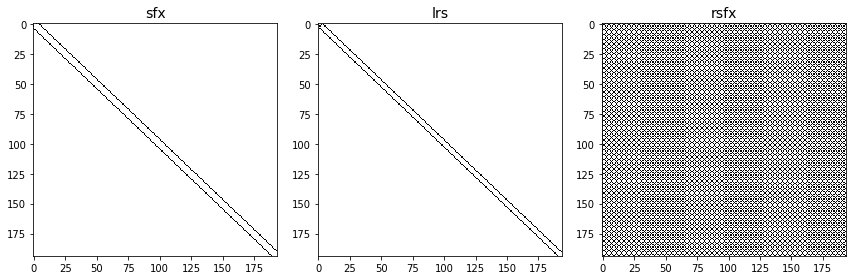

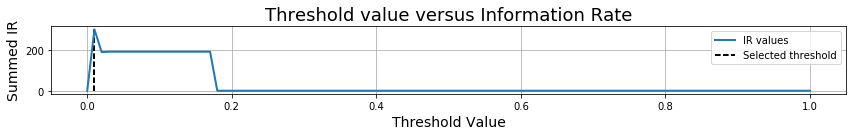

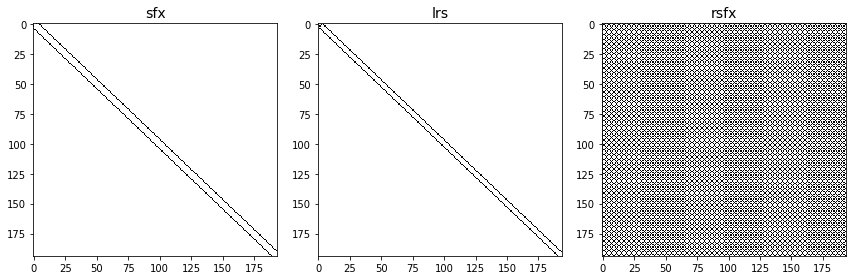

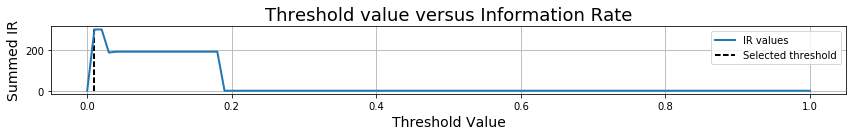

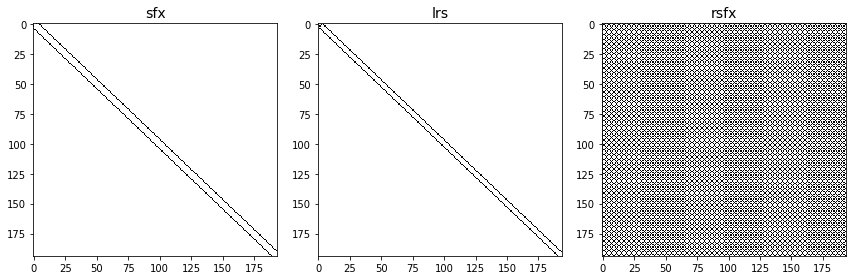

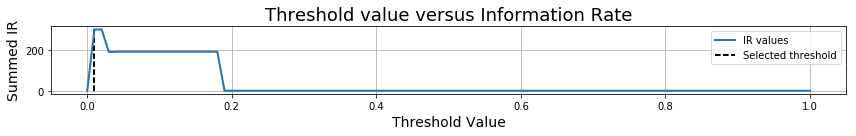

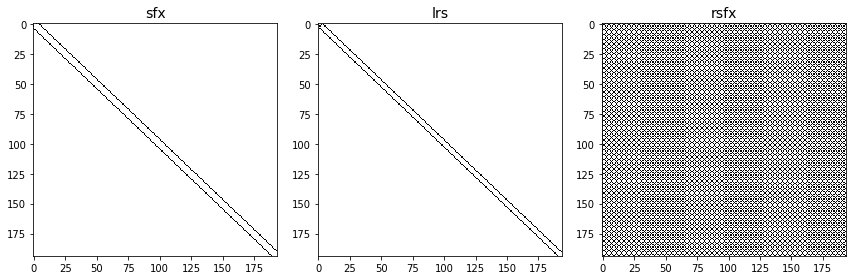

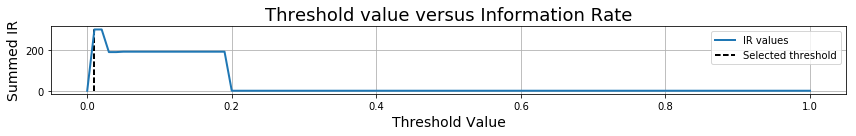

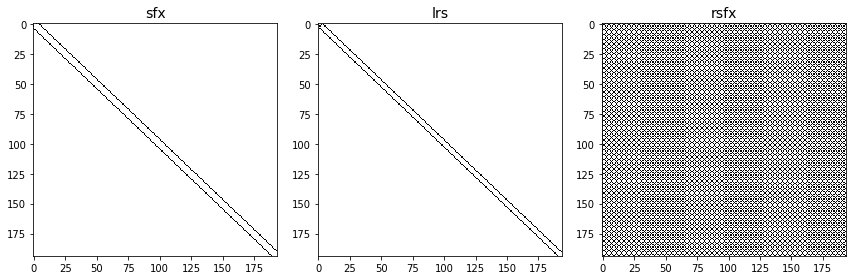

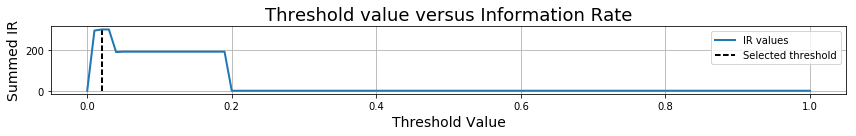

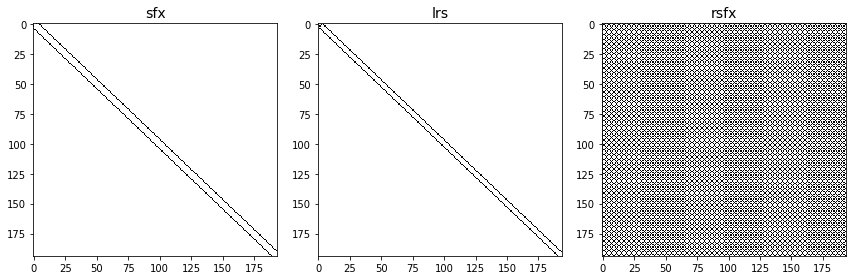

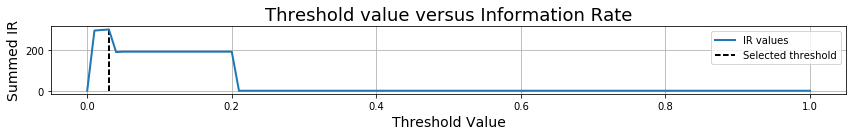

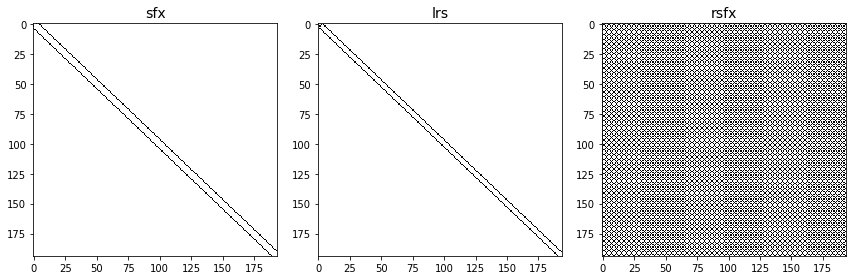

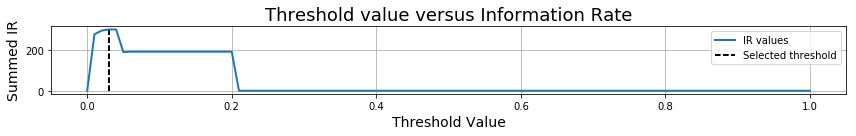

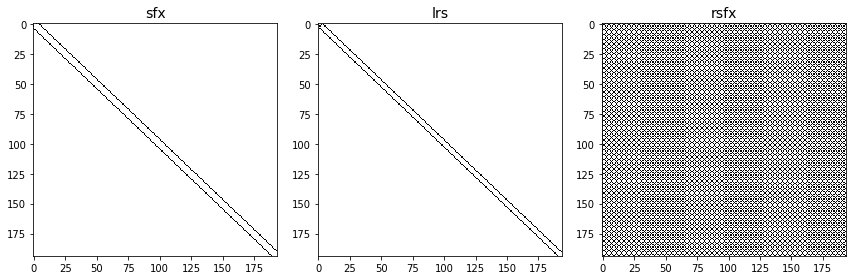

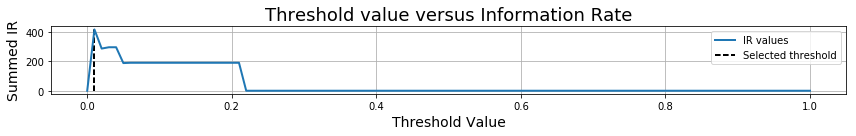

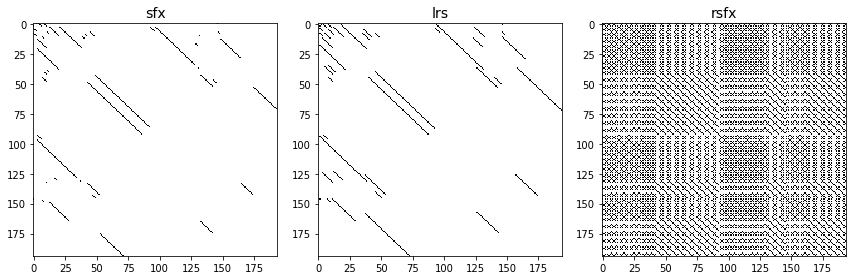

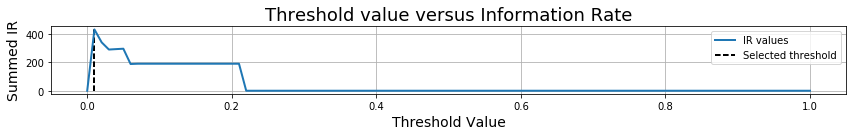

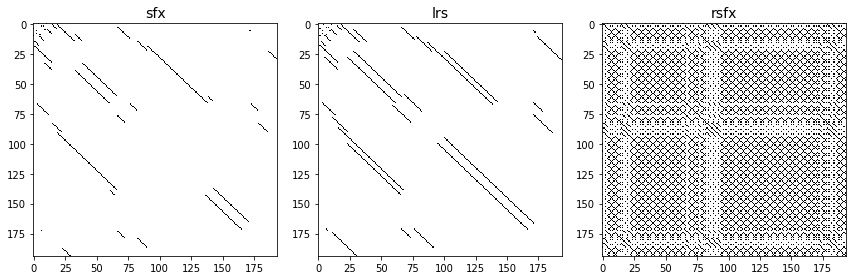

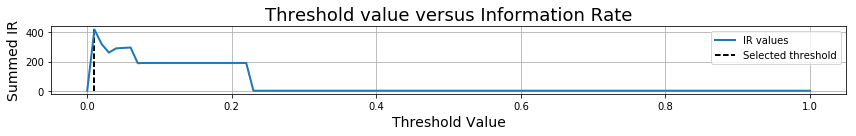

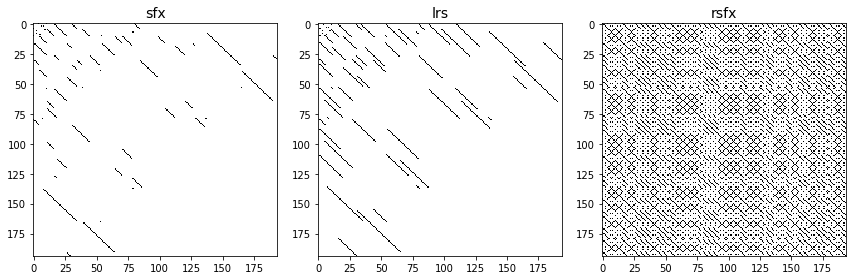

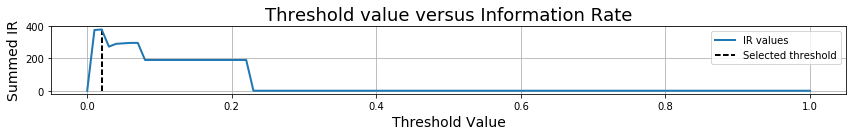

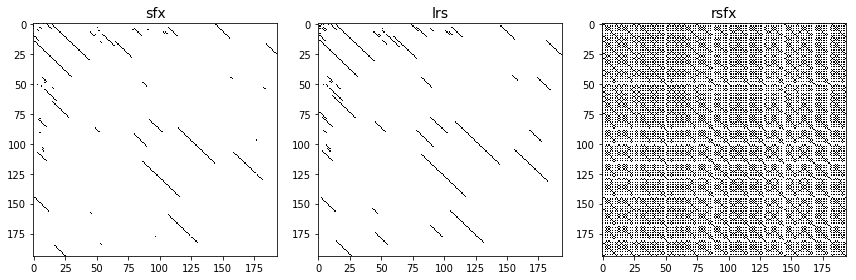

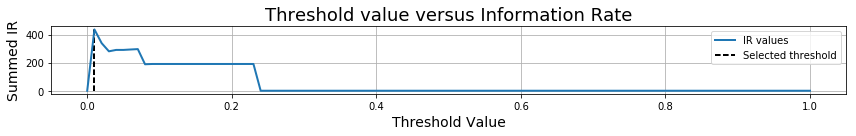

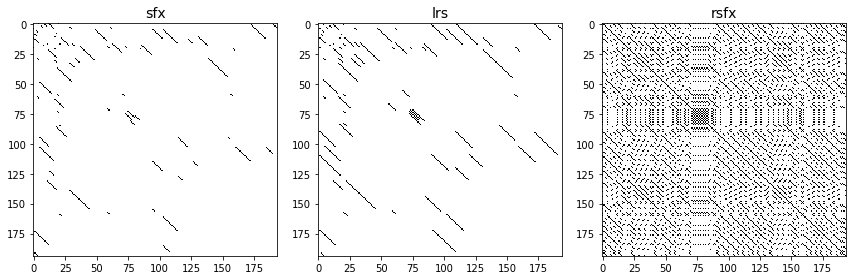

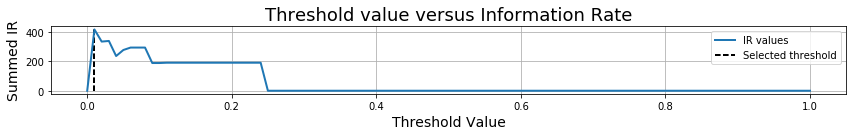

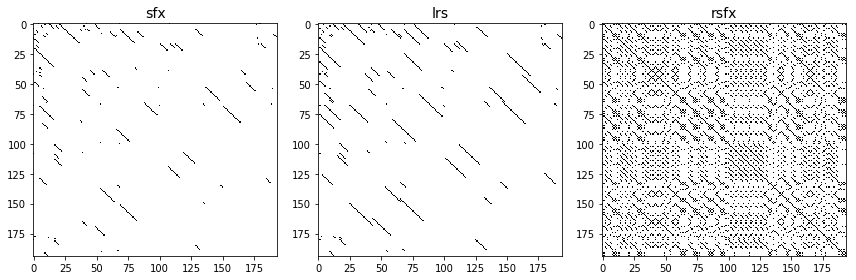

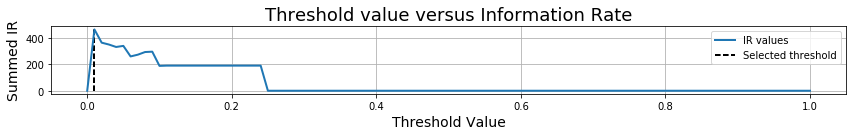

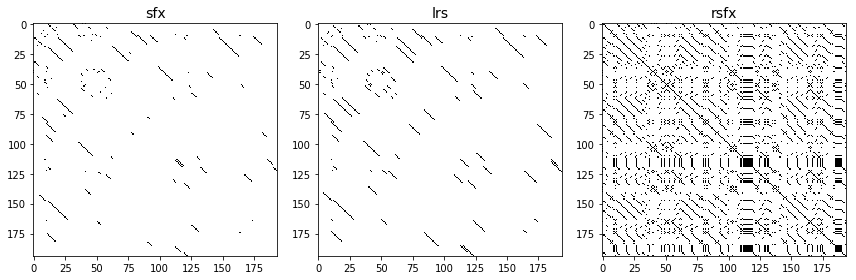

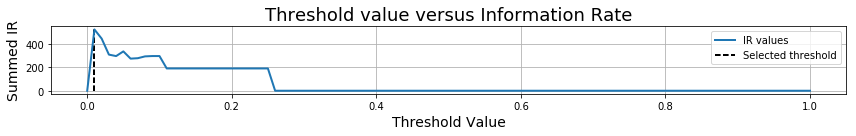

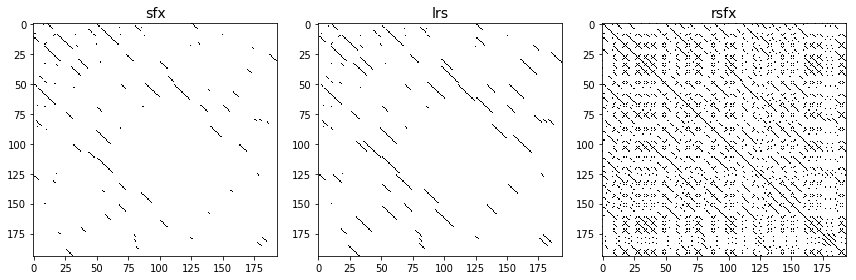

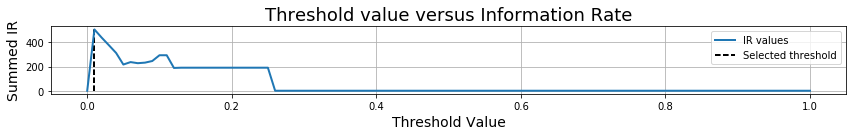

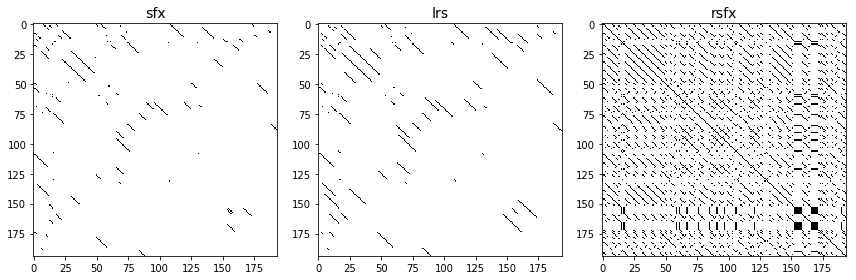

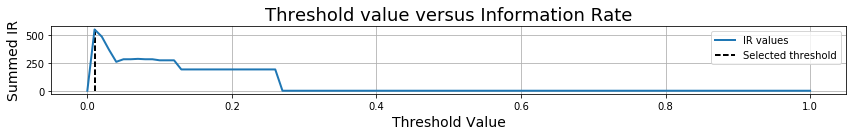

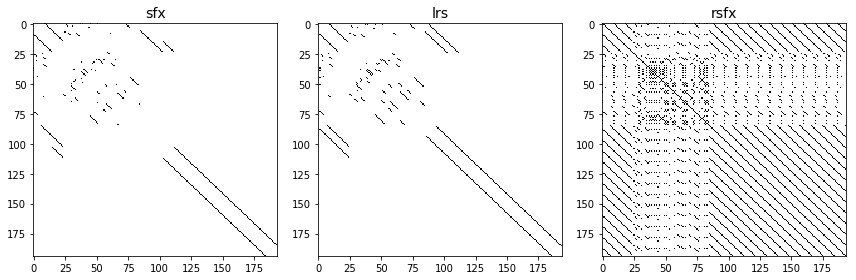

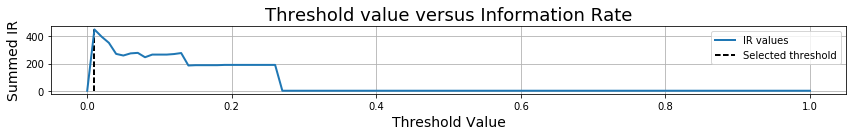

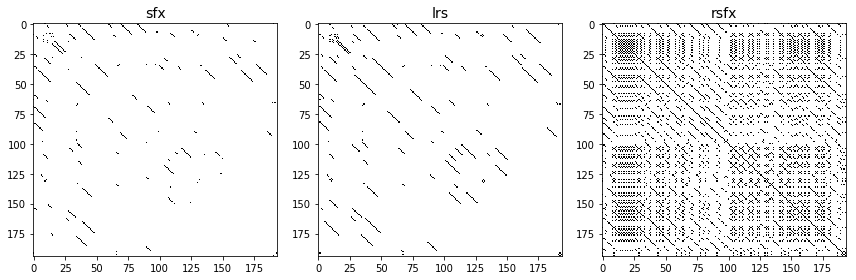

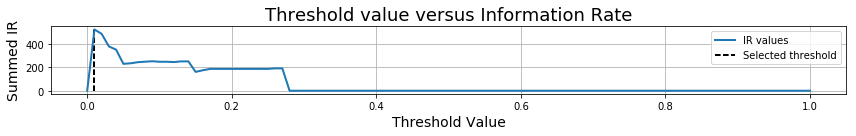

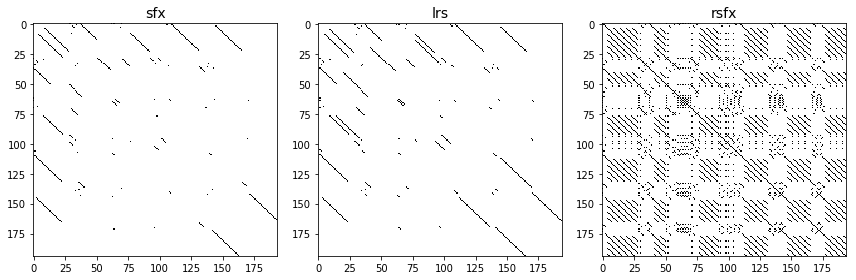

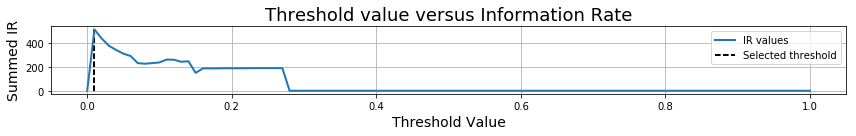

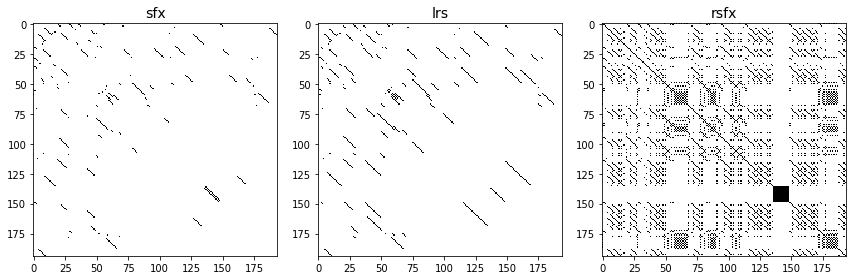

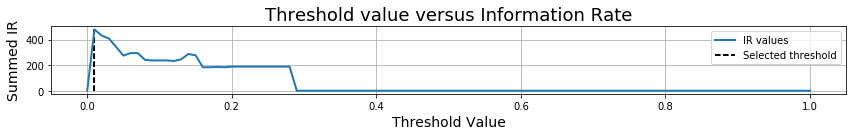

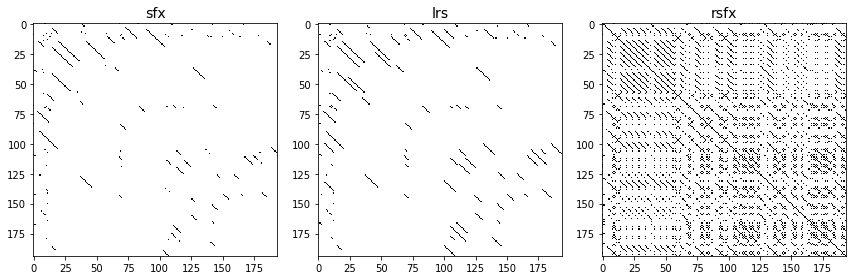

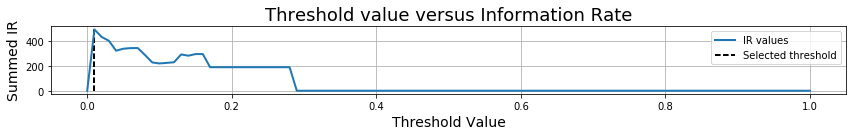

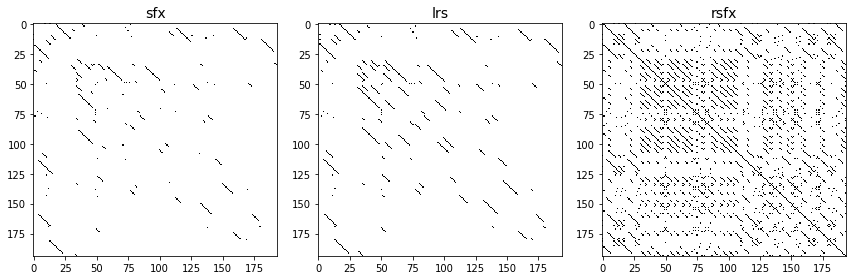

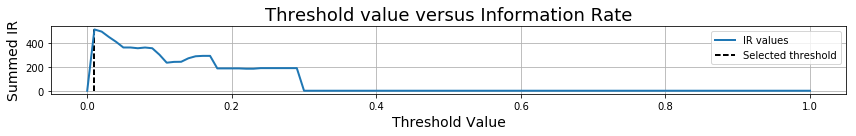

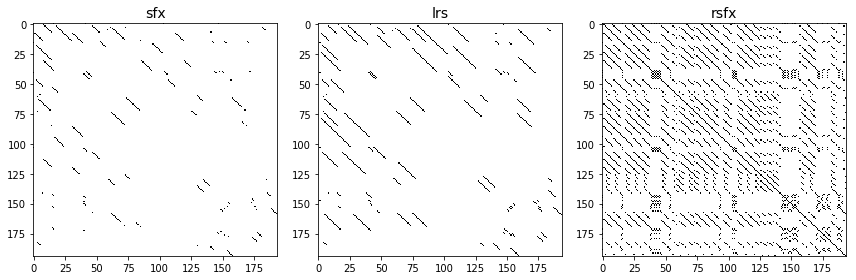

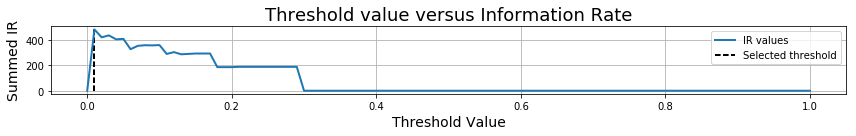

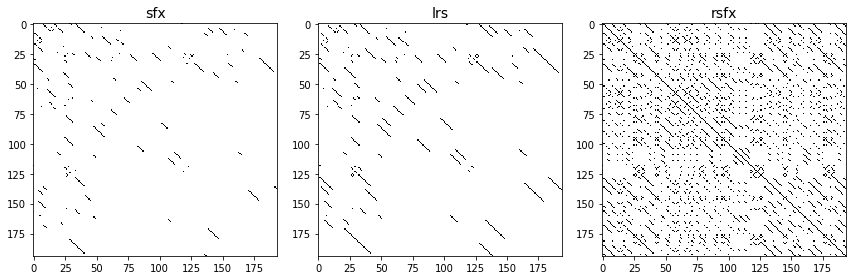

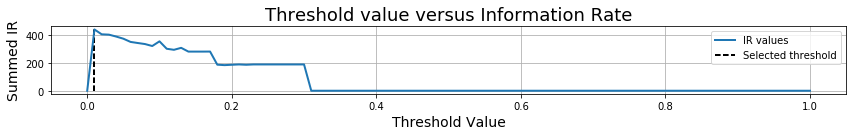

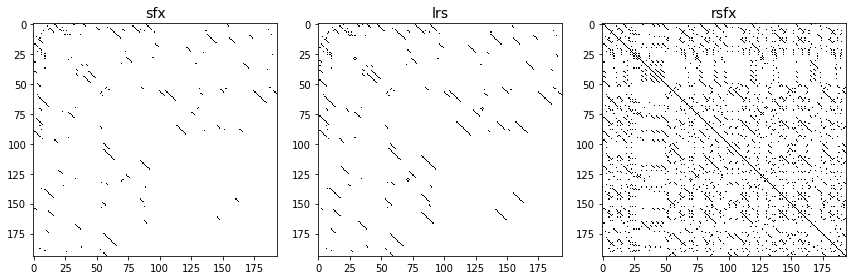

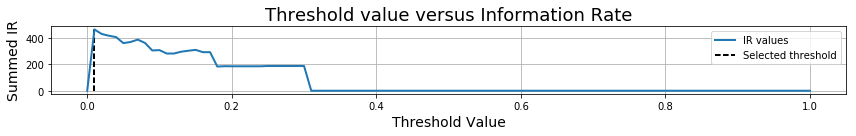

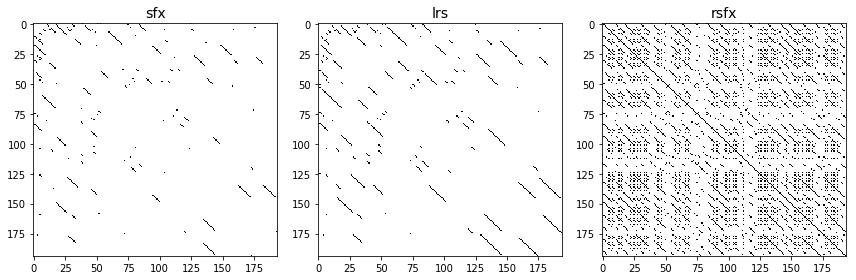

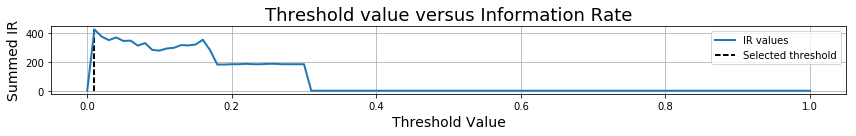

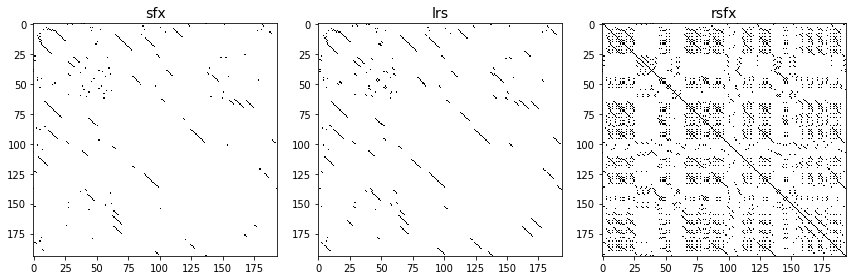

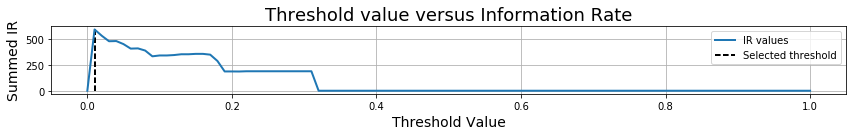

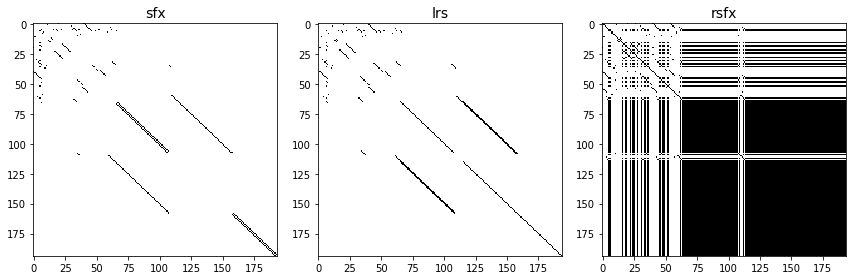

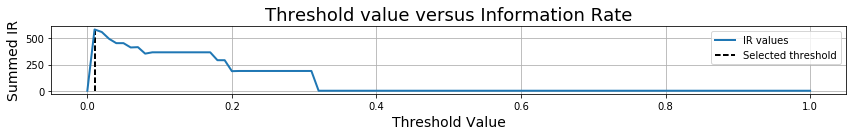

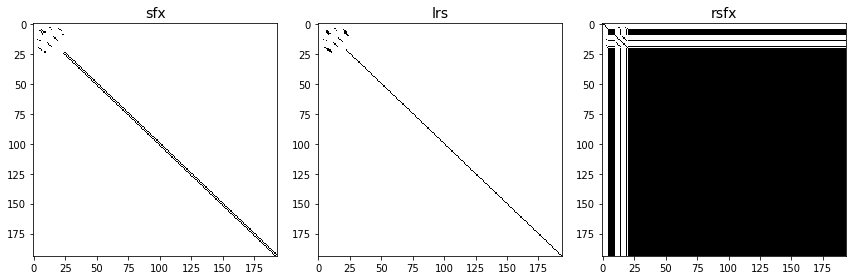

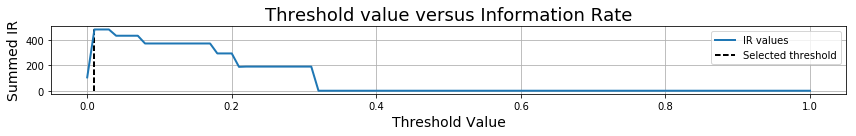

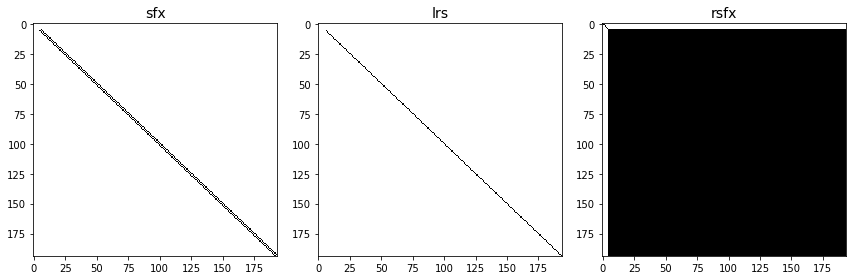

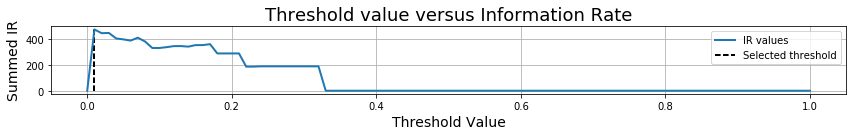

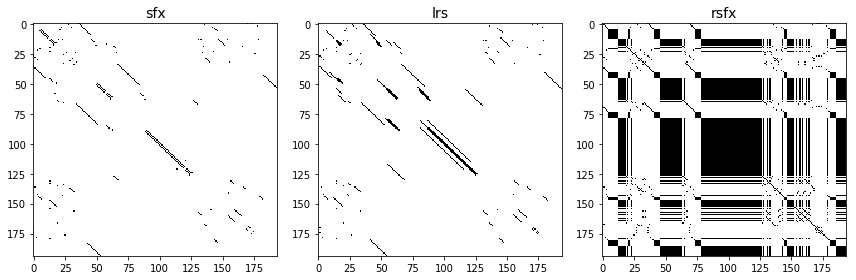

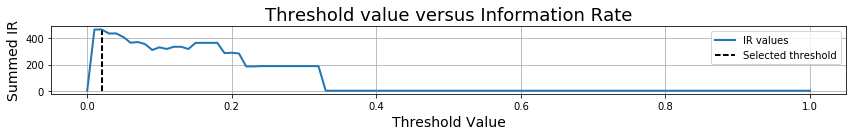

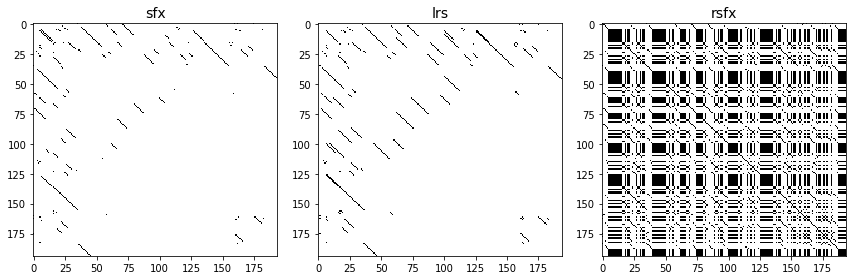

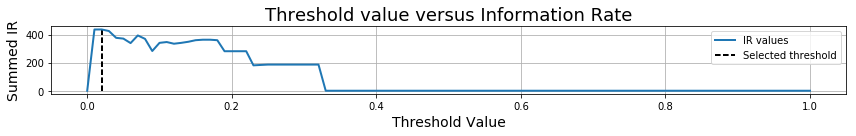

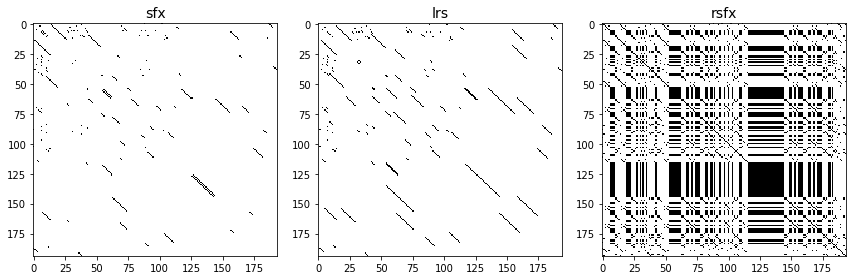

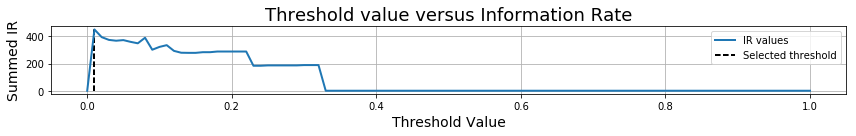

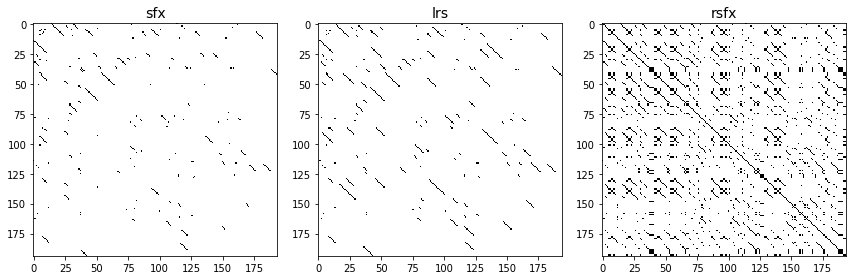

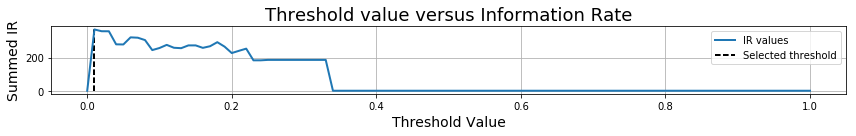

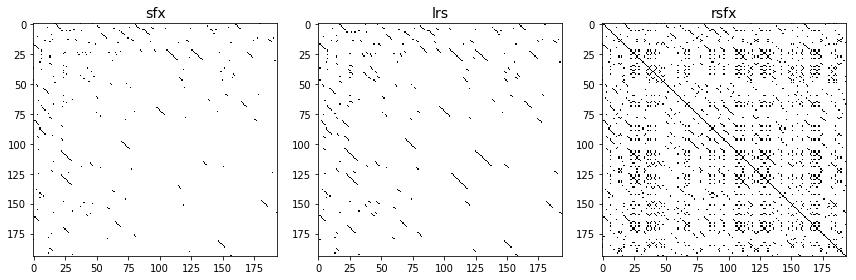

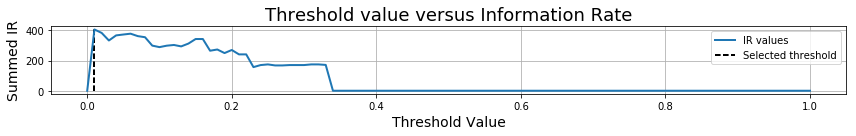

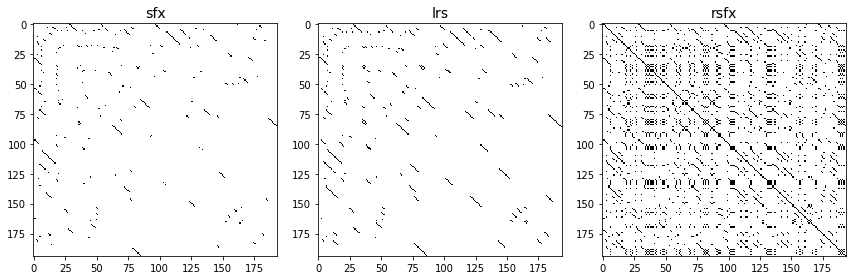

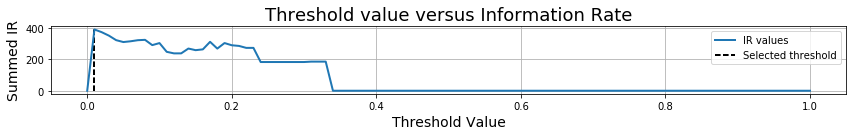

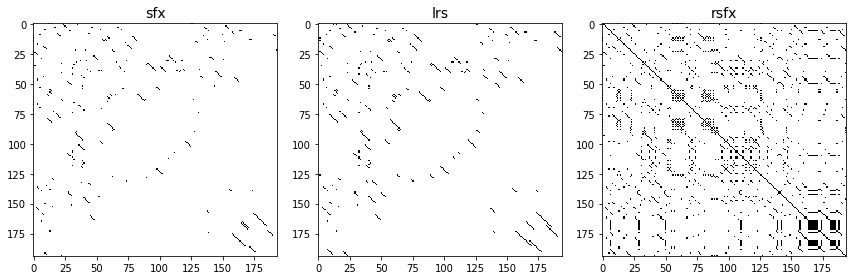

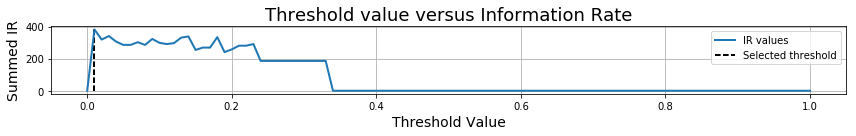

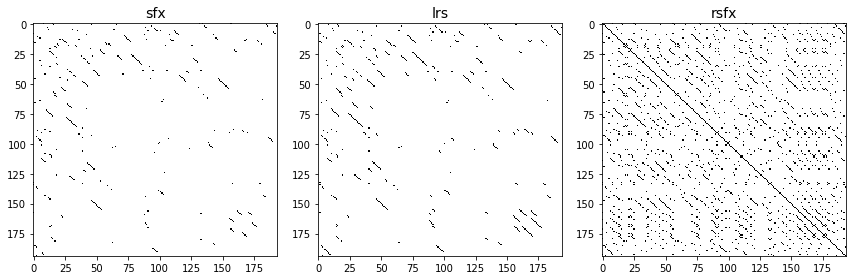

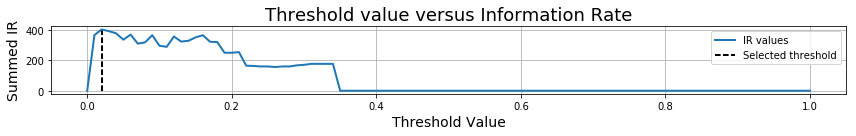

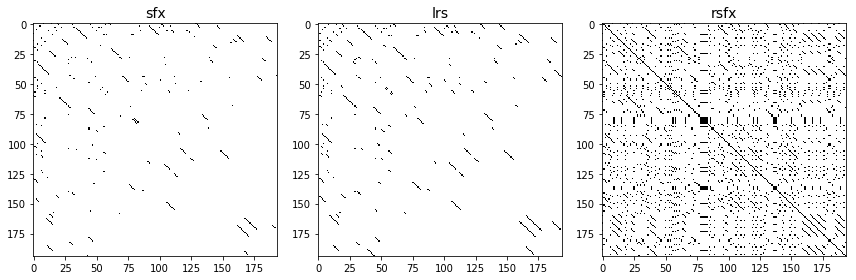

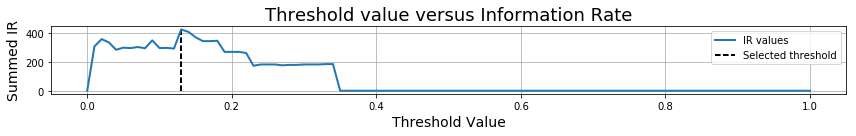

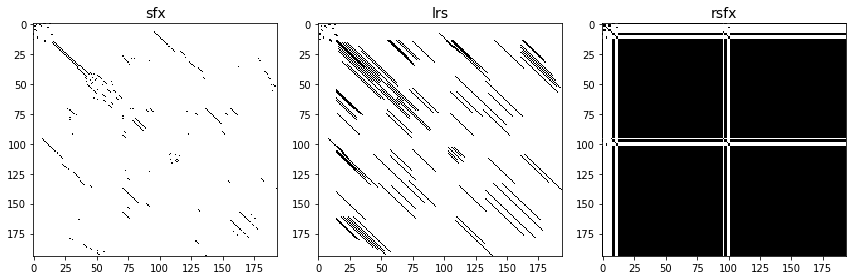

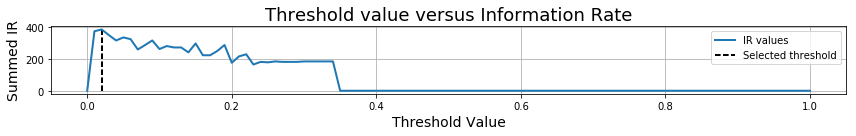

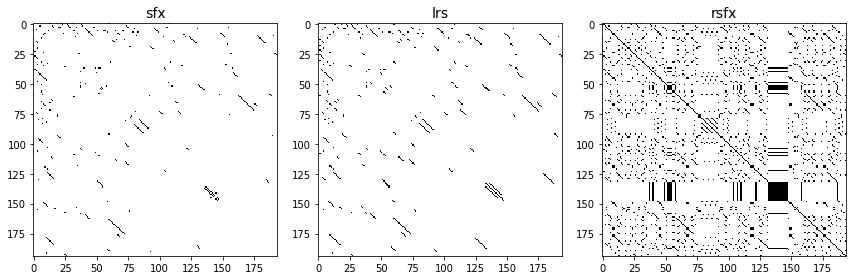

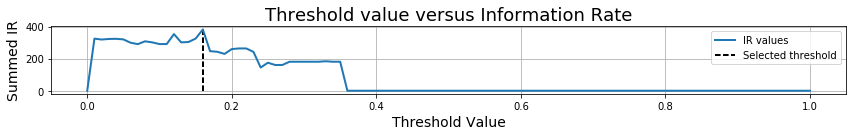

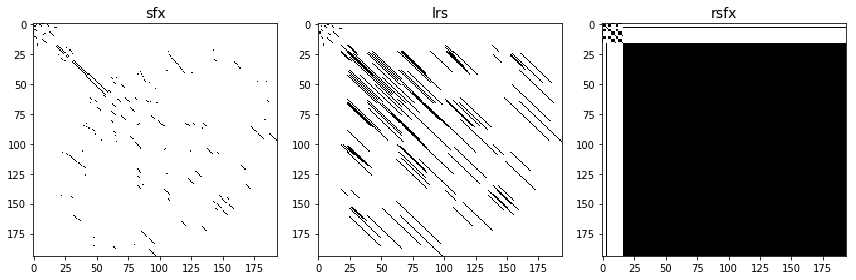

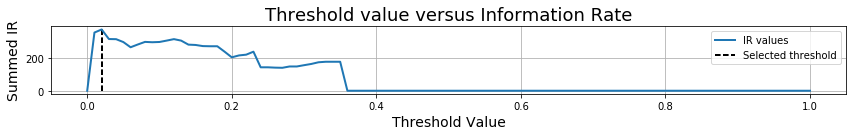

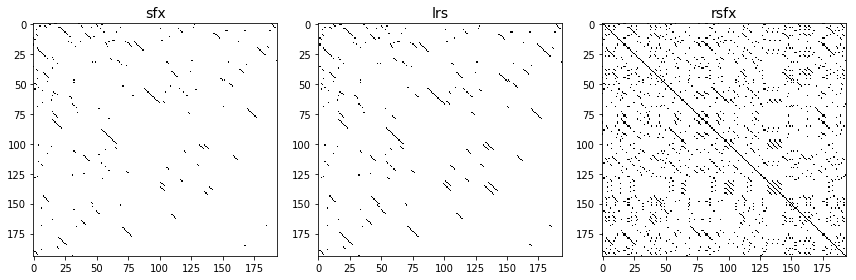

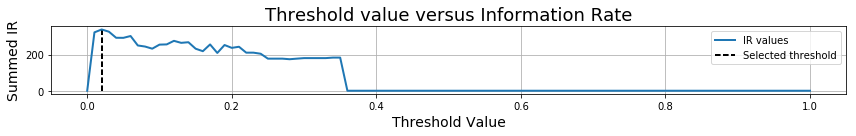

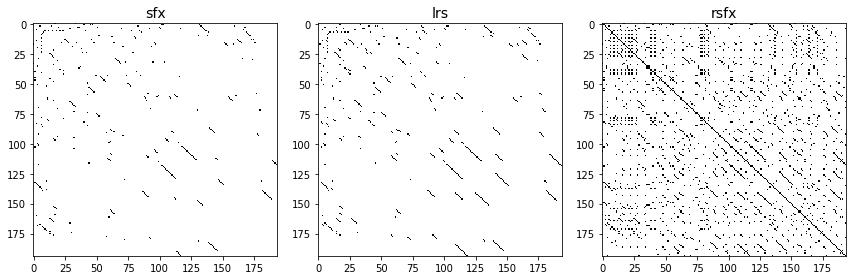

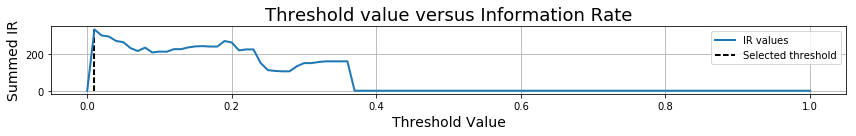

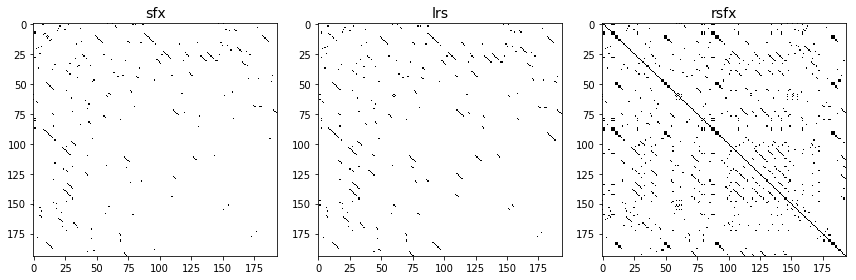

In [31]:
from scipy.stats import entropy
import entropy as ent


Rvalues = np.linspace(3.0, 4.0, 100)

#Rvalues = [3.0, 3.449489, 3.544090, 3.564407, 3.568750, 3.56969, 3.56989, 3.569934, 3.569943, 3.569945, 3.569945, 3.569945, 3.626553, 3.701640, 3.738172, 3.828427, 3.918682, 3.9422, 3.985913, 4.0]

bifr_len = len(Rvalues)
time_S = [] # list of [r, timeseries]
le = np.zeros(len(Rvalues))
x0 = 0.8
T = 200

r_threshold = (0, 1.01, 0.01)
dim = 3
tau = 3

det = np.empty(bifr_len)
rr = np.empty(bifr_len)
div = np.empty(bifr_len)
lam = np.empty(bifr_len)
k2 = np.empty(bifr_len)
KS = np.empty(bifr_len)
ir = np.empty(bifr_len)
scipy_entropy = np.empty(bifr_len)
epsilon = np.empty(bifr_len)
LE = np.empty(bifr_len)

scipy_entropy2 = np.empty(bifr_len)

idx = 0
for b in range (0,bifr_len):
    tseries = logisticmap(x0, Rvalues[b], T)    
    time_S.append([Rvalues[b], tseries]) #save r and corresponding timeseries
    #LE[b] = lyapunov_exponent(tseries, Rvalues[b])
    emb_ts = timeseries_embedding(tseries, dim, tau) # embed the timeseries
    
    #print "R = ", Rvalues[b], "."
    ts_vmo,eps, IR  = VMO_GEN(emb_ts, r_threshold, dim) # get the VMO
    
    ir[b] = IR # optimal VMO-IR 
    epsilon[b] = eps #ideal VMO-Threshold
    
    LE[b] = lyapunov_exponent(ts_vmo.lrs, Rvalues[b])
    
    
    recurrence_vmo = Recurrence_VMO(ts_vmo)    

    #rqa = RQA(ts_vmo)
    diag_stats = Diagonals(recurrence_vmo) 
    det[b] = Determinism(recurrence_vmo, diag_stats[0])
    
    div[b] = Divergence(diag_stats[1])
    rr[b] = Recurrence_Rate(recurrence_vmo)
    vert_stats = Verticals(recurrence_vmo)
    lam[b] = Laminarity(recurrence_vmo, vert_stats[0])
    k2[b] = Correlation_Entropy(recurrence_vmo)
    
    #diagonals contains the lengths of the various diagonals 
    diagonals = diag_stats[2] # diag_stats[2] is array diagonals returned from the function Diagonals.
    hist = np.bincount(int64(diagonals))    
    scipy_entropy[b] = entropy(hist, base=2)      
    KS[b] = scipy_entropy[b] - ir[b]
    
    # double check shannon_entropy with entropy of scipy
    scipy_entropy2[b] = ent.shannon_entropy(hist)
    
    
#for l in range(0,len(time_S)):
    #le[idx] = lyapunov_exponent(time_S[l][1], Rvalues[l])    
    #idx += 1
    
#L_entr = entropy.shannon_entropy('diagonals');
   


In [29]:
print hist
print " "

#print diag_stats[2]

[37451   113    38     8     4     6     8     6     0     2]
 


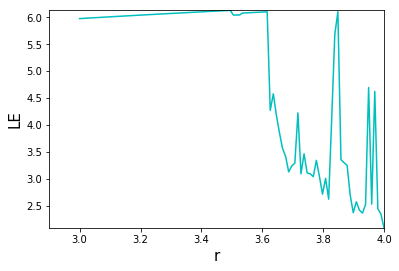

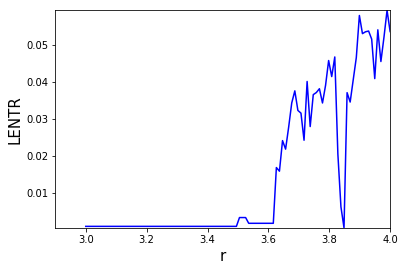

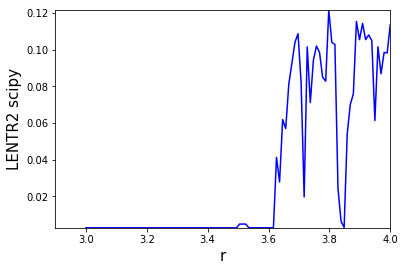

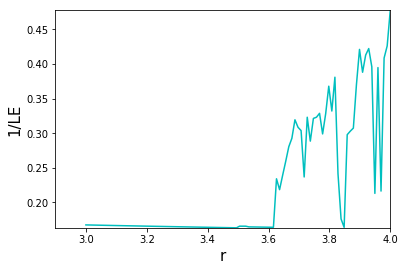

In [32]:
# plots the lyapunov exponent
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('LE', fontsize=15)
R_min=2.9  # range
R_max=4.0  

plt.axis([R_min, R_max, min(LE), max(LE)])
plt.plot(Rvalues, LE,'c-',markersize=8)

#plot LENTR: entropy of diagonal linees
plt.figure()
plt.xlabel(r'r', fontsize=15)
plt.ylabel('LENTR', fontsize=15)
R_min = 2.9
R_max = 4.0

plt.axis([R_min, R_max, min(scipy_entropy), max(scipy_entropy)])
plt.plot(Rvalues, scipy_entropy,'b-',markersize=8)

#plot LENTR: entropy of diagonal linees
plt.figure()
plt.xlabel(r'r', fontsize=15)
plt.ylabel('LENTR2 scipy', fontsize=15)
R_min = 2.9
R_max = 4.0
plt.axis([R_min, R_max, min(scipy_entropy2), max(scipy_entropy2)])
plt.plot(Rvalues, scipy_entropy2,'b-',markersize=8)

# plots the inverse of the lyapunov exponent
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('1/LE', fontsize=15)
R_min=2.9  # range
R_max=4.0  
plt.axis([R_min, R_max, min(1/LE), max(1/LE)])
plt.plot(Rvalues, (1/LE),'c-',markersize=8)




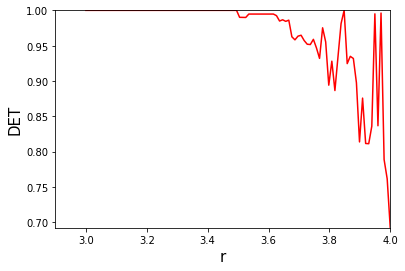

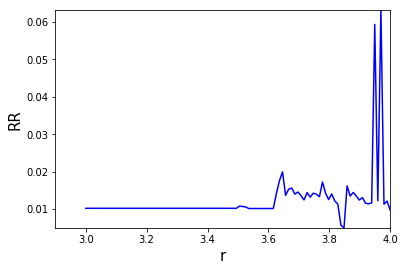

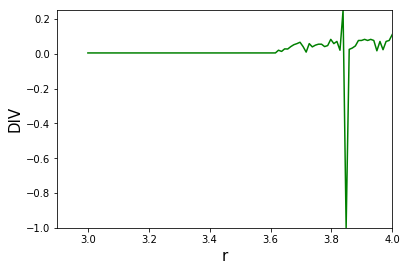

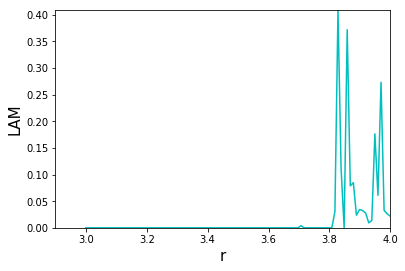

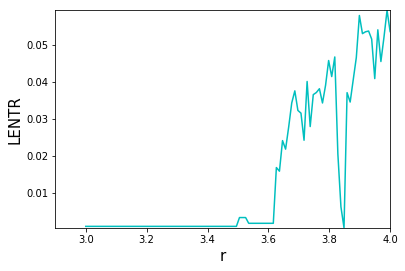

In [22]:
# plot DETERMINISM
# set up the plot
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('DET', fontsize=15)
R_min=2.9  # range
R_max=4.0    
   
plt.axis([R_min, R_max,min(det), max(det)])
plt.plot(Rvalues, det,'r-',markersize=8)

    
# plot RECURRENCE RATE
# set up the plot
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('RR', fontsize=15)
R_min=2.9  # range
R_max=4.0 

plt.axis([R_min, R_max,min(rr), max(rr)])
plt.plot(Rvalues, rr,'b-',markersize=8)
    
    
# plot DIVERGENCE
# set up the plot
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('DIV', fontsize=15)
R_min=2.9  # range
R_max=4.0    
   
plt.axis([R_min, R_max,min(div), max(div)])
plt.plot(Rvalues, div,'g-',markersize=8)
    
# plot LAMINARITY
# set up the plot
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('LAM', fontsize=15)
R_min=2.9  # range
R_max=4.0    
   
plt.axis([R_min, R_max,min(lam), max(lam)])
plt.plot(Rvalues, lam,'c-',markersize=8)


#plot LENTR: entropy of diagonal linees
plt.figure()
plt.xlabel(r'r', fontsize=15)
plt.ylabel('LENTR', fontsize=15)
R_min = 2.9
R_max = 4.0

plt.axis([R_min, R_max, min(scipy_entropy), max(scipy_entropy)])
plt.plot(Rvalues, scipy_entropy,'c-',markersize=8)

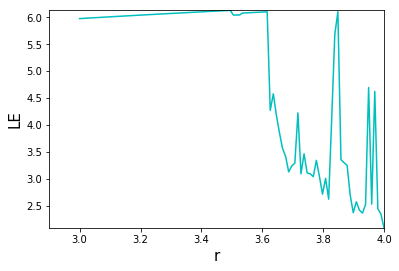

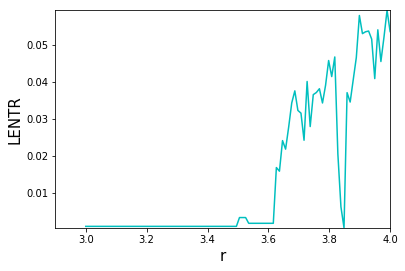

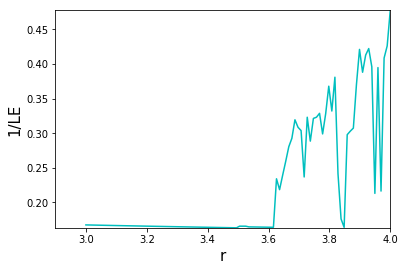

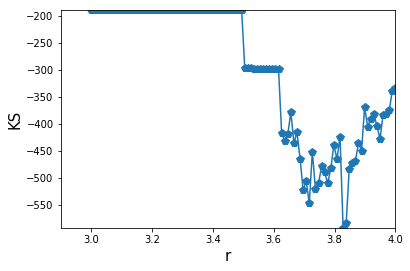

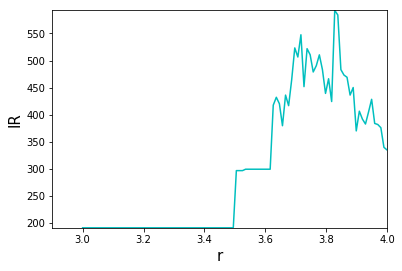

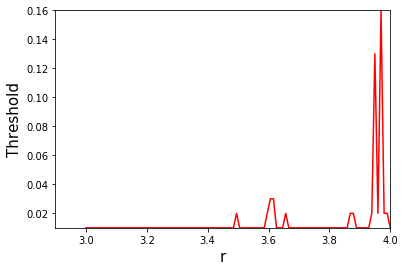

In [63]:


# plot K2
# set up the plot
#plt.figure()
#plt.xlabel(r'r',fontsize=15)
#plt.ylabel('K2', fontsize=15)
#R_min=2.9  # range
#R_max=4.0    

#plt.axis([R_min, R_max,min(k2), max(k2)])
#plt.plot(Rvalues, k2,'m-',markersize=8)


# plots the lyapunov exponent
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('LE', fontsize=15)
R_min=2.9  # range
R_max=4.0  
plt.axis([R_min, R_max, min(LE), max(LE)])
plt.plot(Rvalues, LE,'c-',markersize=8)

#plot LENTR: entropy of diagonal linees
plt.figure()
plt.xlabel(r'r', fontsize=15)
plt.ylabel('LENTR', fontsize=15)
R_min = 2.9
R_max = 4.0
plt.axis([R_min, R_max, min(scipy_entropy), max(scipy_entropy)])
plt.plot(Rvalues, scipy_entropy,'c-',markersize=8)



# plots the Inverse of the lyapunov exponent
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('1/LE', fontsize=15)

plt.axis([R_min, R_max, min(1/LE), max(1/LE)])
plt.plot(Rvalues, 1/LE,'c-',markersize=8)


#plot KS
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('KS', fontsize=15)
R_min=2.9  # range
R_max=4.0  

plt.axis([R_min, R_max, min(KS), max(KS)])
plt.plot(Rvalues, KS,'r-',markersize=8)

#plot KS
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('IR', fontsize=15)
R_min=2.9  # range
R_max=4.0  

plt.axis([R_min, R_max, min(ir), max(ir)])
plt.plot(Rvalues, ir,'c-',markersize=8)

# plot THRESHOLD

plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('Threshold', fontsize=15)
R_min=2.9  # range
R_max=4.0    
   
plt.axis([R_min, R_max,min(epsilon), max(epsilon)])
plt.plot(Rvalues, epsilon,'r-',markersize=8)


In [133]:
#get complexity measures LE, Correlation Dimension D2 and K2 direclty from the time series.

RRvalues = [3.0, 3.449489, 3.544090, 3.564407, 3.568750, 3.56969, 3.56989, 3.569934, 3.569943, 3.569945, 3.569945, 3.569945, 3.626553, 3.701640, 3.738172, 3.828427, 3.918682, 3.9422, 3.985913, 4.0]
T = 200
x0 = 0.8
neww_le = np.empty(bifr_len)
LE1 = np.empty(bifr_len)
LE2 = []#np.empty(bifr_len)
D2 = np.empty(bifr_len) # correlation dimension
correntropy = np.empty(bifr_len) # correlation entropy K2

dim = 3
t = 3
for q in range (0,bifr_len):
    t2series = logisticmap(x0, RRvalues[q], T)    
    LE1[q] = lyap_r(t2series, emb_dim=dim,tau=t)
    D2[q] = corr_dim(t2series, emb_dim=dim)
    correntropy[q] = -log(D2[q])
    LE2.append(lyap_e(t2series, emb_dim=10, tau=t))


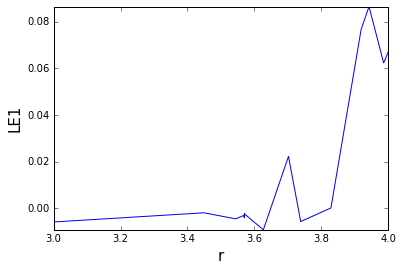

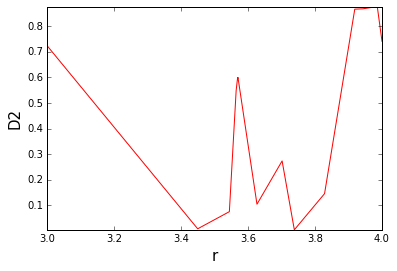

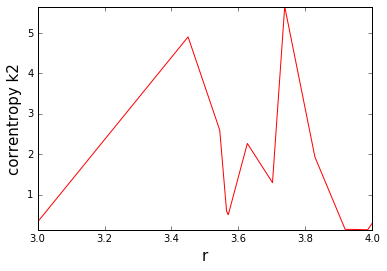

In [134]:
# plots the lyapunov exponent
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('LE1', fontsize=15)
R_min=3.0  # range
R_max=4.0  

plt.axis([R_min, R_max, min(LE1), max(LE1)])
plt.plot(RRvalues, LE1,'b-',markersize=8)


# plots the correlation dimension
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('D2', fontsize=15)
R_min=3.0  # range
R_max=4.0  

plt.axis([R_min, R_max, min(D2), max(D2)])
plt.plot(RRvalues, D2,'r-',markersize=8)

# plots the correlation entropy K2
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('correntropy k2', fontsize=15)
R_min=3.0  # range
R_max=4.0  

plt.axis([R_min, R_max, min(correntropy), max(correntropy)])
plt.plot(RRvalues, correntropy,'r-',markersize=8)

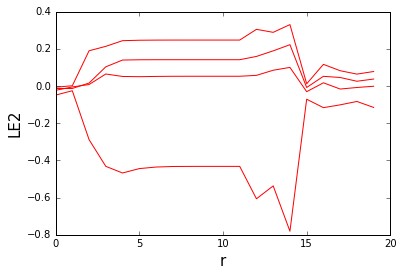

In [135]:
# plot LE spectrum

plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('LE2', fontsize=15)

plt.plot(LE2,'r-',markersize=8)